# **CUSTOMER SEGMENTATION ANALYSIS USING CLUSTERING MODEL**
# **Hasbi Thaufik Oktodila**

# **1. Objectives**

> It is an important information to know what kind of customer we have that uses our product. However, sometimes we don't know where to begin to segment our customer. To know the segmentation of our customer means to know the information of our market. This information can be used to implement a targetted marketing, or maybe expand the market to match the segment we already have. Based on this reason, this assignment is aimed to create a segment of characteristics of customer on their credit card usage. 

# **2. Importing Libraries**

## **2. 1. Libraries and Package**

In [638]:
import pandas as pd             # dataframe handling
import numpy as np              # math operation and array processing
import matplotlib.pyplot as plt # plotting
from matplotlib import rcParams # for matplotlib settings
import seaborn as sns           # plotting

# Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Local Outlier Factor for outlier processing
from sklearn.neighbors import LocalOutlierFactor

# For dimentionality reduction
from sklearn.decomposition import PCA   # PCA

# Model Definition
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering       # K-Means

# Model Evaluation Metrics
from sklearn import metrics

# warning settings
import warnings
warnings.filterwarnings(action='ignore')

## **2. 2. Functions**

In [639]:
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm
def plot_silhouette(model,range_n_clusters,X,model_name):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = model(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')


        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle((f"Silhouette analysis for {model_name} clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

# **3. Data Loading**

> The data is queried from BigQuery using following SQL Queries:

In [640]:
# SELECT * 
# FROM `ftds-hacktiv8-project.phase1_ftds_002_hck.credit-card-information`
# WHERE MOD(CUST_ID,2) = 0

> Loading the CSV files downloaded from BigQuery

In [641]:
df = pd.read_csv('h8dsft_P1G4_hasbi-thaufik-oktodila.csv')
df

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0         788    16.581535           0.125000     200.00              0.00   
1        1902   943.584041           0.875000     103.00            103.00   
2        2322     1.979916           0.125000      80.00             80.00   
3        3426   461.455720           1.000000     585.00            585.00   
4        3976  1053.594730           1.000000    1450.00           1450.00   
...       ...          ...                ...        ...               ...   
4470     4630  1079.008102           1.000000       0.00              0.00   
4471     8614   809.582978           0.909091       0.00              0.00   
4472     4296  3386.490883           1.000000     560.98            427.22   
4473     4476  4840.545574           1.000000    1595.93           1595.93   
4474     3564  1977.007090           1.000000    1032.04            226.90   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                     200.00      0.000000             0.125000   
1                       0.00      0.000000             0.125000   
2                       0.00      0.000000             0.125000   
3                       0.00      0.000000             0.125000   
4                       0.00      0.000000             0.125000   
...                      ...           ...                  ...   
4470                    0.00   1259.571764             0.000000   
4471                    0.00   3819.672466             0.000000   
4472                  133.76   2008.153534             1.000000   
4473                    0.00   4359.325750             0.454545   
4474                  805.14   4335.919227             0.909091   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000000                          0.125000   
1                       0.125000                          0.000000   
2                       0.125000                          0.000000   
3                       0.125000                          0.000000   
4                       0.125000                          0.000000   
...                          ...                               ...   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.727273                          0.363636   
4473                    0.454545                          0.000000   
4474                    0.090909                          0.818182   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000                 0              2        1200.0   
1                   0.000000                 0              1        1000.0   
2                   0.000000                 0              1        1500.0   
3                   0.000000                 0              1        1000.0   
4                   0.000000                 0              1        1500.0   
...                      ...               ...            ...           ...   
4470                0.545455                 9              0        1200.0   
4471                0.545455                 7              0        4150.0   
4472                0.545455                 9             20       10100.0   
4473                0.545455                17             25        6000.0   
4474                0.545455                21             17        4000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0        0.000000               NaN          0.000000       8  
1      215.325023        410.484825          0.000000       8  
2        0.000000               NaN          0.000000       8  
3      258.032630        151.696433          0.000000       8  
4      397.090516        227.143184          0.000000       8  
...           ...               ...               ...     ...  
4470  1379.635287        2

> Checking the data info

In [642]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

> All the column has numerical data types. Proceeding to data-cleaning...

# **4. Data Cleaning**

## **4. 1. Handling Null Values**

> Checking the nulls..

In [643]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

> There's two columns with null values: credit_limit and minimum_payment.<br>
> Since the amount is not that many compared to the whole data, nulls will be dropped.

In [644]:
df.dropna(inplace=True)
df.isnull().any()

CUST_ID                             False
BALANCE                             False
BALANCE_FREQUENCY                   False
PURCHASES                           False
ONEOFF_PURCHASES                    False
INSTALLMENTS_PURCHASES              False
CASH_ADVANCE                        False
PURCHASES_FREQUENCY                 False
ONEOFF_PURCHASES_FREQUENCY          False
PURCHASES_INSTALLMENTS_FREQUENCY    False
CASH_ADVANCE_FREQUENCY              False
CASH_ADVANCE_TRX                    False
PURCHASES_TRX                       False
CREDIT_LIMIT                        False
PAYMENTS                            False
MINIMUM_PAYMENTS                    False
PRC_FULL_PAYMENT                    False
TENURE                              False
dtype: bool

In [645]:
df.duplicated().any()

False

In [646]:
df.describe().T

count         mean          std  \
CUST_ID                           4316.0  4474.638554  2589.259871   
BALANCE                           4316.0  1600.114511  2107.347942   
BALANCE_FREQUENCY                 4316.0     0.895236     0.206730   
PURCHASES                         4316.0  1025.274057  2241.729131   
ONEOFF_PURCHASES                  4316.0   600.770438  1690.105736   
INSTALLMENTS_PURCHASES            4316.0   424.888909   940.627467   
CASH_ADVANCE                      4316.0   986.980658  2159.134558   
PURCHASES_FREQUENCY               4316.0     0.495675     0.399564   
ONEOFF_PURCHASES_FREQUENCY        4316.0     0.205447     0.299252   
PURCHASES_INSTALLMENTS_FREQUENCY  4316.0     0.369805     0.398217   
CASH_ADVANCE_FREQUENCY            4316.0     0.136236     0.200511   
CASH_ADVANCE_TRX                  4316.0     3.252549     6.576772   
PURCHASES_TRX                     4316.0    14.801900    24.473182   
CREDIT_LIMIT                      4316.0  4524.431479  3688.856008   
PAYMENTS                          4316.0  1785.801612  2997.093142   
MINIMUM_PAYMENTS                  4316.0   854.624165  2306.642962   
PRC_FULL_PAYMENT                  4316.0     0.162997     0.299700   
TENURE                            4316.0    11.531511     1.324580   

                                         min          25%          50%  \
CUST_ID                             2.000000  2241.500000  4475.000000   
BALANCE                             0.000000   152.877191   916.693628   
BALANCE_FREQUENCY                   0.000000     0.909091     1.000000   
PURCHASES                           0.000000    44.662500   379.300000   
ONEOFF_PURCHASES                    0.000000     0.000000    35.955000   
INSTALLMENTS_PURCHASES              0.000000     0.000000    95.845000   
CASH_ADVANCE                        0.000000     0.000000     0.000000   
PURCHASES_FREQUENCY                 0.000000     0.083333     0.500000   
ONEOFF_PURCHASES_FREQUENCY          0.000000     0.000000     0.083333   
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000     0.000000     0.181818   
CASH_ADVANCE_FREQUENCY              0.000000     0.000000     0.000000   
CASH_ADVANCE_TRX                    0.000000     0.000000     0.000000   
PURCHASES_TRX                       0.000000     1.000000     7.000000   
CREDIT_LIMIT                      150.000000  1500.000000  3000.000000   
PAYMENTS                            4.841543   427.905948   874.442322   
MINIMUM_PAYMENTS                    0.037744   169.878606   309.983200   
PRC_FULL_PAYMENT                    0.000000     0.000000     0.000000   
TENURE                              6.000000    12.000000    12.000000   

                                          75%           max  
CUST_ID                           6712.500000   8950.000000  
BALANCE                           2112.447004  19043.138560  
BALANCE_FREQUENCY                    1.000000      1.000000  
PURCHASES                         1149.940000  49039.570000  
ONEOFF_PURCHASES                   600.000000  40761.250000  
INSTALLMENTS_PURCHASES             498.592500  22500.000000  
CASH_ADVANCE                      1110.248526  29282.109150  
PURCHASES_FREQUENCY                  0.916667      1.000000  
ONEOFF_PURCHASES_FREQUENCY           0.333333      1.000000  
PURCHASES_INSTALLMENTS_FREQUENCY     0.750000      1.000000  
CASH_ADVANCE_FREQUENCY               0.250000      1.166667  
CASH_ADVANCE_TRX                     4.000000    110.000000  
PURCHASES_TRX                       17.000000    358.000000  
CREDIT_LIMIT                      6500.000000  30000.000000  
PAYMENTS                          1954.888216  46930.598240  
MINIMUM_PAYMENTS                   830.656813  61031.618600  
PRC_FULL_PAYMENT                     0.166667      1.000000  
TENURE                              12.000000     12.000000

> From data's general info, there's no abnormalities so far.

> Renaming the column to lower case

In [647]:
print(df.columns)

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')


In [648]:
df.columns= df.columns.str.lower()
df.columns

Index(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure'],
      dtype='object')

In [649]:
df.head(1)

cust_id     balance  balance_frequency  purchases  oneoff_purchases  \
1     1902  943.584041              0.875      103.0             103.0   

   installments_purchases  cash_advance  purchases_frequency  \
1                     0.0           0.0                0.125   

   oneoff_purchases_frequency  purchases_installments_frequency  \
1                       0.125                               0.0   

   cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
1                     0.0                 0              1        1000.0   

     payments  minimum_payments  prc_full_payment  tenure  
1  215.325023        410.484825               0.0       8

> Splitting for inference:

In [650]:
df_inf = df.sample(30, random_state=42069)
df = df.drop(df_inf.index)

print('Inference Shape: ', df_inf.shape)
print('Main Dataframe Shape',df.shape)

Inference Shape:  (30, 18)
Main Dataframe Shape (4286, 18)


# **5. Data Exploratory Analysis**

## **5. 1. Univariate Analysis**

array([[<AxesSubplot:title={'center':'cust_id'}>,
        <AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'balance_frequency'}>,
        <AxesSubplot:title={'center':'purchases'}>],
       [<AxesSubplot:title={'center':'oneoff_purchases'}>,
        <AxesSubplot:title={'center':'installments_purchases'}>,
        <AxesSubplot:title={'center':'cash_advance'}>,
        <AxesSubplot:title={'center':'purchases_frequency'}>],
       [<AxesSubplot:title={'center':'oneoff_purchases_frequency'}>,
        <AxesSubplot:title={'center':'purchases_installments_frequency'}>,
        <AxesSubplot:title={'center':'cash_advance_frequency'}>,
        <AxesSubplot:title={'center':'cash_advance_trx'}>],
       [<AxesSubplot:title={'center':'purchases_trx'}>,
        <AxesSubplot:title={'center':'credit_limit'}>,
        <AxesSubplot:title={'center':'payments'}>,
        <AxesSubplot:title={'center':'minimum_payments'}>],
       [<AxesSubplot:title={'center':'prc_full_payment

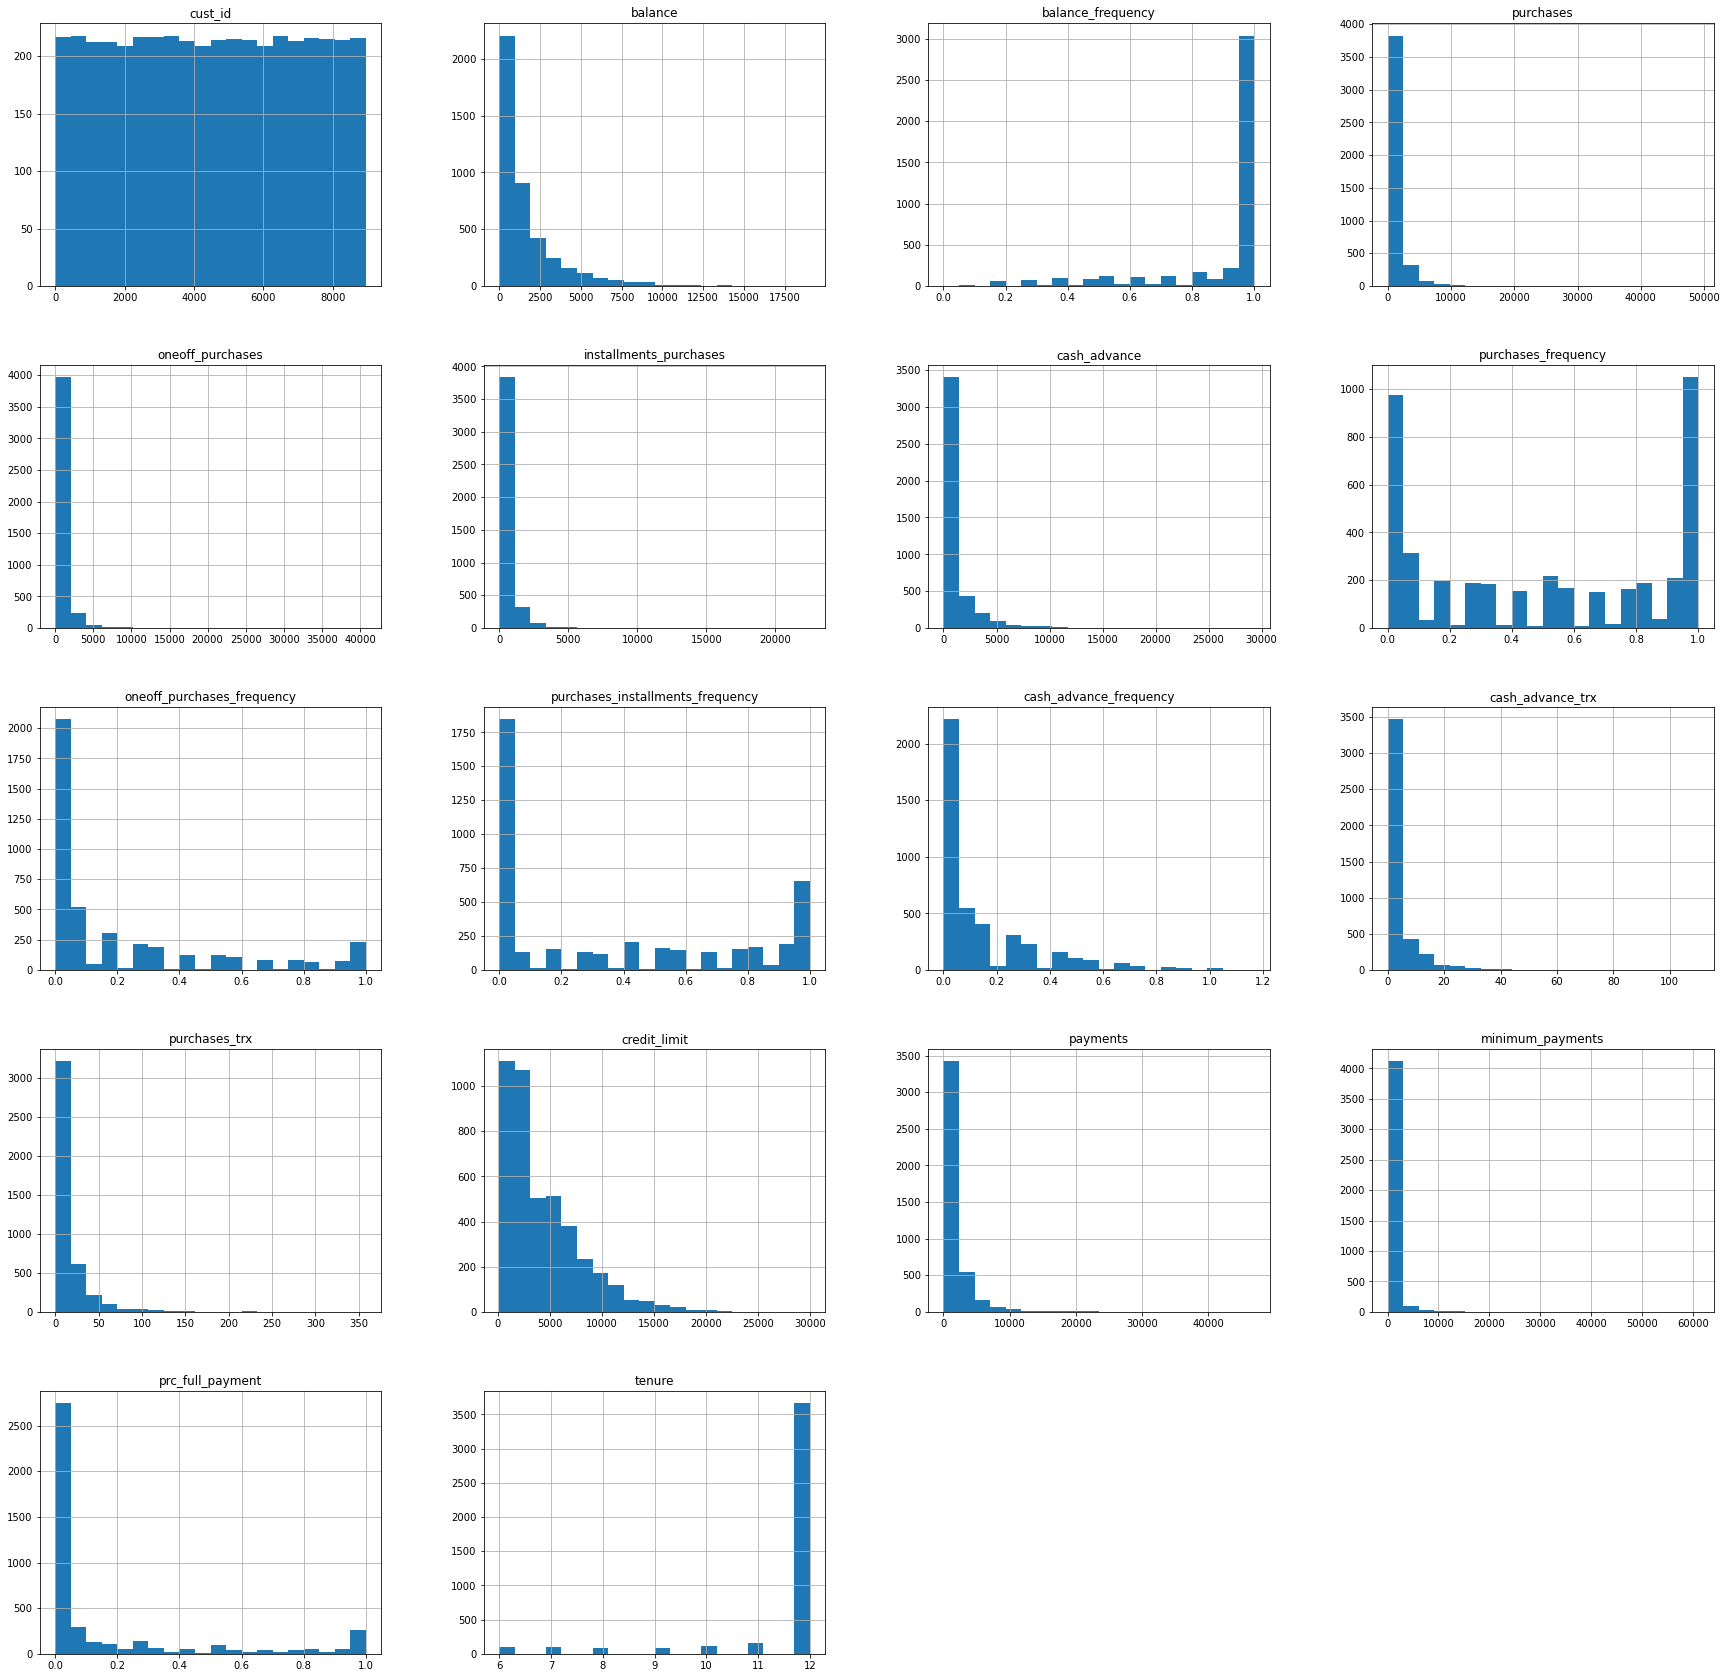

In [651]:
df.hist(figsize = (30,30), bins=20)

In [652]:
for col in df.columns:
    print(f'Skewness {col}', df[col].skew())

Skewness cust_id -0.000383744068473064
Skewness balance 2.4507123509227546
Skewness balance_frequency -2.0799999241511617
Skewness purchases 8.891325380116085
Skewness oneoff_purchases 10.029517902779586
Skewness installments_purchases 8.042689635652762
Skewness cash_advance 4.728010163311095
Skewness purchases_frequency 0.03428078427004817
Skewness oneoff_purchases_frequency 1.4910100919021456
Skewness purchases_installments_frequency 0.4854808324958201
Skewness cash_advance_frequency 1.7916237727964202
Skewness cash_advance_trx 4.731977603313044
Skewness purchases_trx 4.420965480591563
Skewness credit_limit 1.5261621205150115
Skewness payments 5.978281395722564
Skewness minimum_payments 12.32835719206946
Skewness prc_full_payment 1.8478162196836851
Skewness tenure -3.002499893579215


Insight:

> - Categorical columns   : `tenure`. Representing month from June (6) to December (12)
> - Numerical columns     : every column except `tenure`<br>
> - Irrelevant columns    : `cust_id`. Will be dropped since it won't give information in order to cluster the data.
> - Normal Distribution   : `purchases_installments_frequency`<br>
> - Skewed          : other than `purchases_installments_frequency`



In [653]:
df.drop(['cust_id'], axis=1, inplace=True)
df.columns

Index(['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment',
       'tenure'],
      dtype='object')

> Setting up the numericals and categoricals as lists

In [654]:
nums = ['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment']
cats = ['tenure']

> Scaling the data before processing any further

In [655]:
# scaler=StandardScaler()
# df_scaled = scaler.fit_transform(df)
# df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df.columns)
# df_scaled.head()

> Let's proceed to see the outliers

## **5. 2. Outlier Analysis**

This section is aimed to observe the outliers distribution since we will use K-means as one of clustering model.

> Counting the amount of column to set a subplots

In [656]:
len(df.columns)

17

> Setting the boxplot subplots

balance skewness :  2.4507123509227546
balance_frequency skewness :  -2.0799999241511617
purchases skewness :  8.891325380116085
oneoff_purchases skewness :  10.029517902779586
installments_purchases skewness :  8.042689635652762
cash_advance skewness :  4.728010163311095
purchases_frequency skewness :  0.03428078427004817
oneoff_purchases_frequency skewness :  1.4910100919021456
purchases_installments_frequency skewness :  0.4854808324958201
cash_advance_frequency skewness :  1.7916237727964202
cash_advance_trx skewness :  4.731977603313044
purchases_trx skewness :  4.420965480591563
credit_limit skewness :  1.5261621205150115
payments skewness :  5.978281395722564
minimum_payments skewness :  12.32835719206946
prc_full_payment skewness :  1.8478162196836851


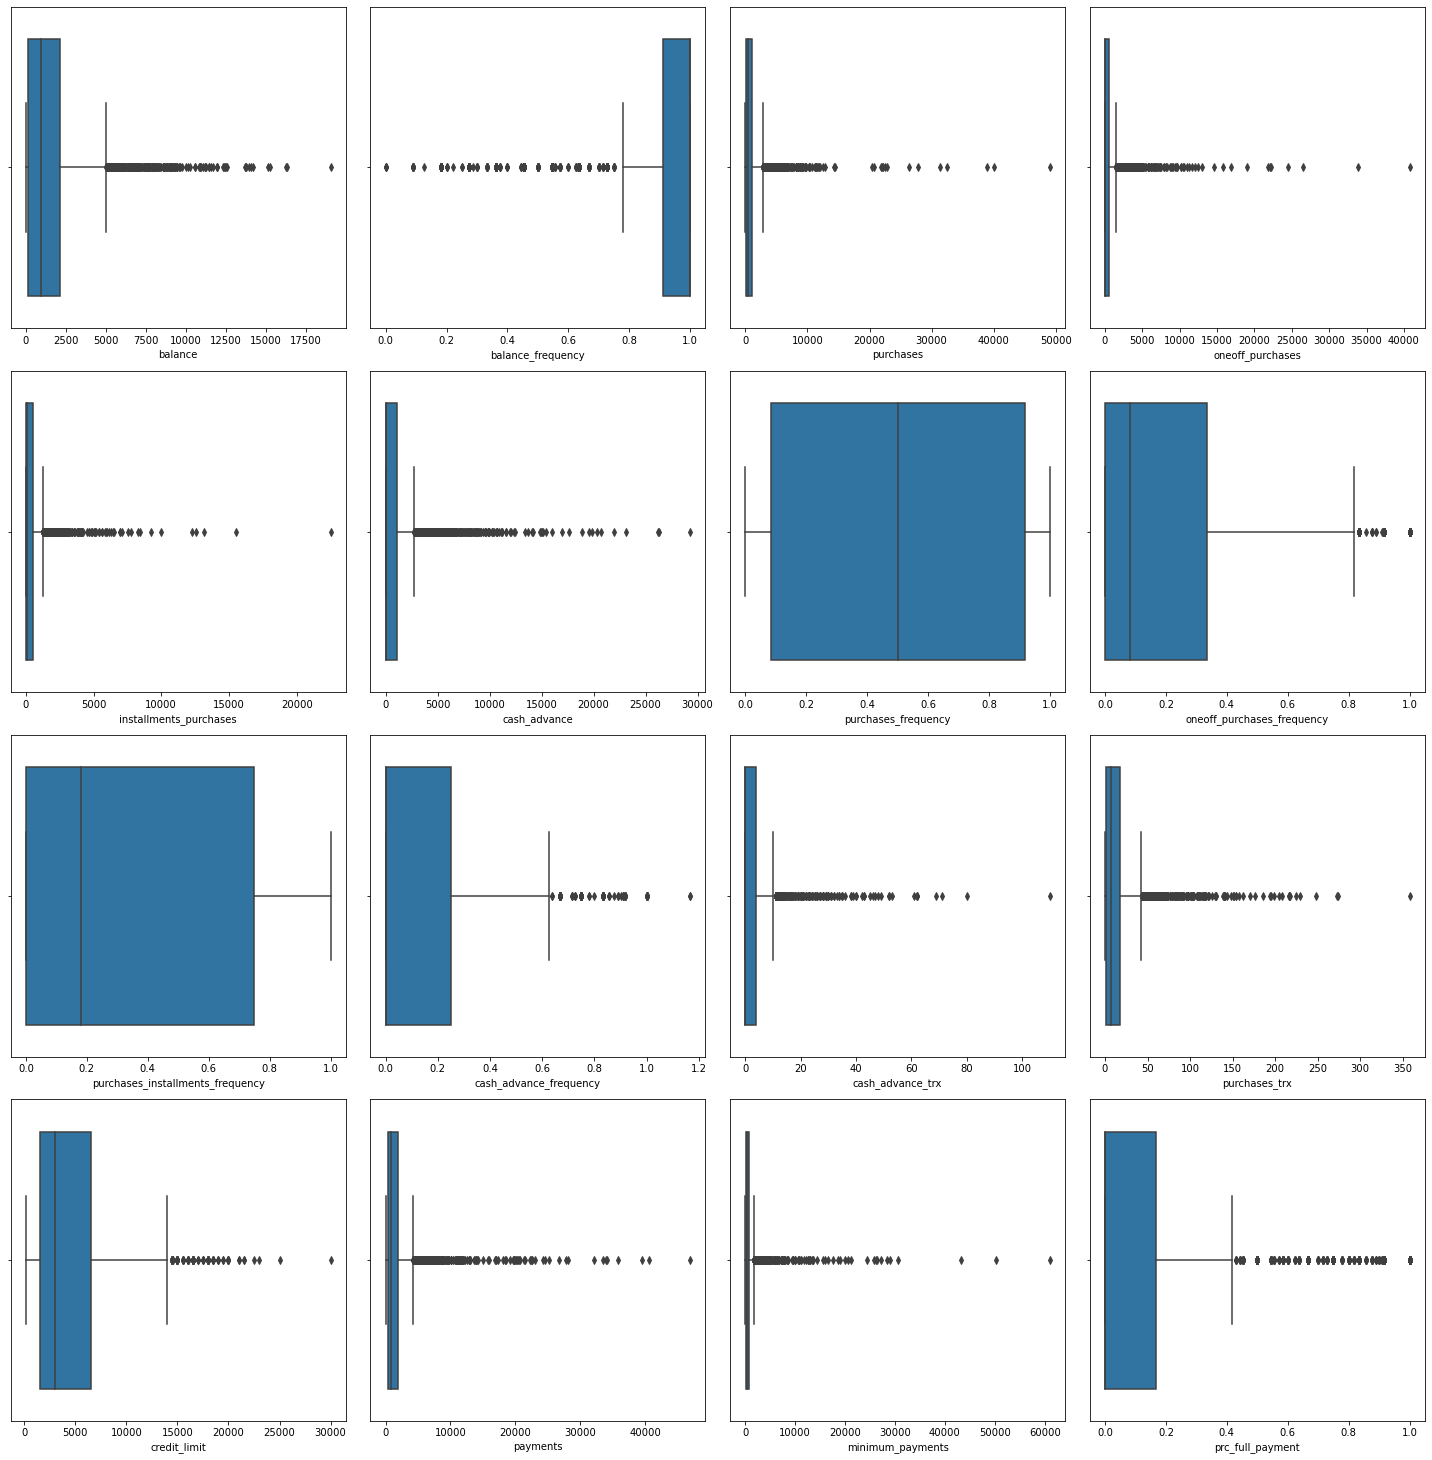

In [657]:
cols = 4
rows = 5
num_cols = df[['balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment']].columns
fig = plt.figure( figsize=(cols*5, rows*5))

for i, col in enumerate(num_cols):
    ax=fig.add_subplot(rows,cols,i+1)
    sns.boxplot(x = df[col], ax = ax)
    print(f'{col} skewness : ', df[col].skew())
    
fig.tight_layout()  
plt.show()

> Now let's see how many outliers on each column, using IQR method

In [658]:
def outlier_analysis(df,col):
  skewness = df[col].skew()
  if skewness>=-0.5 and skewness<=0.5:
    upper = df[col].mean() + 3*df[col].std()
    lower = df[col].mean() - 3*df[col].std()
  else:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    upper = Q3 + (3 * IQR)
    lower = Q1 - (3 * IQR)

  no_outliers = df[(df[col]>=lower) &  (df[col]<=upper)]
  outliers = df[(df[col]<lower) | (df[col]>upper)]

  return outliers,no_outliers, upper, lower

cols_name = ['balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment']

for i in cols_name:
    out,no_out, up, low = outlier_analysis (df,i)
    print(i)
    print('count of outlier: ', len(out))
    print('percentage of outlier: ', (len(out)/len(df))*100, '%') 
    print('-'*10)

balance
count of outlier:  97
percentage of outlier:  2.263182454503033 %
----------
balance_frequency
count of outlier:  495
percentage of outlier:  11.549230051329912 %
----------
purchases
count of outlier:  172
percentage of outlier:  4.013065795613626 %
----------
oneoff_purchases
count of outlier:  256
percentage of outlier:  5.9729351376574895 %
----------
installments_purchases
count of outlier:  174
percentage of outlier:  4.059729351376575 %
----------
cash_advance
count of outlier:  237
percentage of outlier:  5.529631357909473 %
----------
purchases_frequency
count of outlier:  0
percentage of outlier:  0.0 %
----------
oneoff_purchases_frequency
count of outlier:  0
percentage of outlier:  0.0 %
----------
purchases_installments_frequency
count of outlier:  0
percentage of outlier:  0.0 %
----------
cash_advance_frequency
count of outlier:  2
percentage of outlier:  0.04666355576294914 %
----------
cash_advance_trx
count of outlier:  177
percentage of outlier:  4.129724685

> It seems that there are so many outliers on many columns. The highest one is `balance_frequency` which is 13% of its column are categorized as outliers. Dropping this will be such a loss of information. There are also possibilities that there are multiple outliers on one row. To see the wider view of the outliers, we will use Local Outlier Factor (LOF)

> Let's test it without scaling first

In [659]:
lof = LocalOutlierFactor(n_neighbors = 20,contamination=.03)
df2 = df.copy()
df2['lof'] = lof.fit_predict(df2)
df2['negative_outlier_factor'] = lof.negative_outlier_factor_
outlier = df2[df2['lof'] == -1]
outlier

balance  balance_frequency  purchases  oneoff_purchases  \
40     193.103834           1.000000     246.56            246.56   
49     936.370785           1.000000     158.45            158.45   
101    126.159165           1.000000     144.90            144.90   
150    588.795215           0.636364    4116.00              0.00   
155   2791.930619           1.000000     231.52              0.00   
...           ...                ...        ...               ...   
4306  1455.745146           1.000000     266.00            266.00   
4382    32.779456           1.000000     212.58            160.48   
4388  8823.284205           1.000000    3719.00           2293.18   
4428   182.514528           1.000000     157.67              0.00   
4446  1871.597836           1.000000    3220.25            208.49   

      installments_purchases  cash_advance  purchases_frequency  \
40                      0.00      0.000000             0.250000   
49                      0.00      0.000000             0.250000   
101                     0.00      0.000000             0.250000   
150                  4116.00      0.000000             0.500000   
155                   231.52      0.000000             0.500000   
...                      ...           ...                  ...   
4306                    0.00    168.514165             0.222222   
4382                   52.10    279.524631             0.500000   
4388                 1425.82  29282.109150             1.000000   
4428                  157.67    214.943660             0.916667   
4446                 3011.76   2367.006699             0.833333   

      oneoff_purchases_frequency  purchases_installments_frequency  \
40                      0.250000                          0.000000   
49                      0.250000                          0.000000   
101                     0.250000                          0.000000   
150                     0.000000                          0.500000   
155                     0.000000                          0.500000   
...                          ...                               ...   
4306                    0.222222                          0.000000   
4382                    0.333333                          0.166667   
4388                    0.750000                          1.000000   
4428                    0.000000                          0.916667   
4446                    0.166667                          0.750000   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
40                  0.000000                 0              3         600.0   
49                  0.000000                 0              3        1700.0   
101                 0.000000                 0              6         450.0   
150                 0.000000                 0             12       21500.0   
155                 0.000000                 0              6        3000.0   
...                      ...               ...            ...           ...   
4306                0.222222                 2              4        1500.0   
4382                0.416667                 5              8        1500.0   
4388                0.416667                26             61       15500.0   
4428                0.416667                 6             11        1000.0   
4446                0.416667                15             28        5500.0   

          payments  minimum_payments  prc_full_payment  tenure  lof  \
40     3540.713522       1987.489882          0.083333      12   -1   
49      160.698863        443.538283          0.000000      12   -1   
101    1307.853194       1336.106153          0.333333      12   -1   
150    8130.112361        224.763498          1.000000      12   -1   
155    1828.411354       1109.449182          0.000000      12   -1   
...            ...               ...               ...     ...  ...   
4306    284.966485        302.737808          0.000000       9   -1   
4382    338.583630

> 130 rows total. The amount that is still acceptable to drop.

In [660]:
df = df.drop(outlier.index)

> Now that we removed the outliers, proceeding to PCA...

# **6. Feature Engineering (Dimensionality Reduction**)

## **6. 1. Principal Component Analysis (PCA)**

### **6. 1. 1. Feature Scaling**

Scaling will be conducted with standard scaler

> df before scaled:

In [664]:
df.head()

balance  balance_frequency  purchases  oneoff_purchases  \
1   943.584041              0.875      103.0             103.0   
3   461.455720              1.000      585.0             585.0   
4  1053.594730              1.000     1450.0            1450.0   
5  2237.238086              1.000      120.0             120.0   
7   424.994385              0.375     1200.0            1200.0   

   installments_purchases  cash_advance  purchases_frequency  \
1                     0.0           0.0                0.125   
3                     0.0           0.0                0.125   
4                     0.0           0.0                0.125   
5                     0.0           0.0                0.125   
7                     0.0           0.0                0.125   

   oneoff_purchases_frequency  purchases_installments_frequency  \
1                       0.125                               0.0   
3                       0.125                               0.0   
4                       0.125                               0.0   
5                       0.125                               0.0   
7                       0.125                               0.0   

   cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
1                     0.0                 0              1        1000.0   
3                     0.0                 0              1        1000.0   
4                     0.0                 0              1        1500.0   
5                     0.0                 0              1        2500.0   
7                     0.0                 0              1        1200.0   

     payments  minimum_payments  prc_full_payment  tenure  
1  215.325023        410.484825               0.0       8  
3  258.032630        151.696433               0.0       8  
4  397.090516        227.143184               0.0       8  
5  343.102984        712.986387               0.0       8  
7   57.266292         56.720210               0.0       8

> df after scaled:

In [665]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
#df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df.columns)
#df_scaled.head()

> Now that the data has been scaled, proceeding to PCA

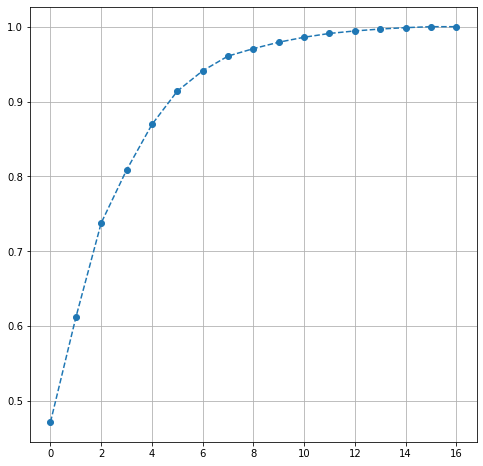

In [666]:
pca=PCA()
pca.fit(df_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(cumsum,'o--')
plt.grid()
plt.show()

> Let's see how a package KneeLocator works on choosing the dimension

In [667]:
from kneed import KneeLocator
from sklearn.cluster import KMeans

kl = KneeLocator(range(0, 17), cumsum, curve="concave", direction="increasing")

kl.knee

5

> From KneeLocator, the located knee for dimension is 5. But for now, let's choose 95% information. Let's compare both of them.

> Setting up PCA with 90% data information:

In [668]:
df_pca=PCA(n_components=0.90).fit_transform(df_scaled)
print('Dimension with 90% data information: ',len(pd.DataFrame(df_pca).columns))

Dimension with 90% data information:  6


> Setting up PCA with 6 dimensions (KneeLocator Package)

In [669]:
df_pca2=PCA(n_components=5).fit_transform(df_scaled)
print('Dimension: ',len(pd.DataFrame(df_pca2).columns))

Dimension:  5


# **7. Model Definition**

## **7. 1. K-Means**

> Showing the elbow of each type of data frame (scaled ones, pca with 90% information, and pca with 5 dimensions)

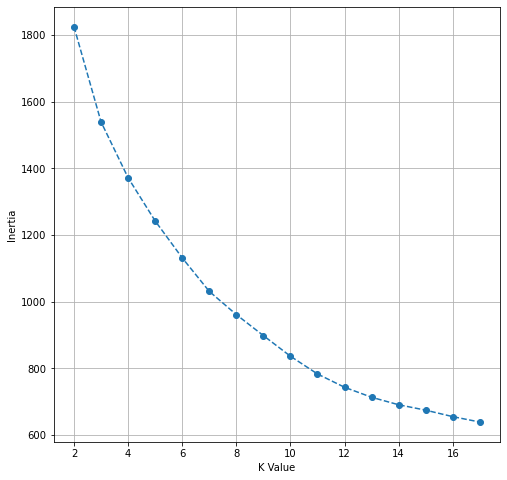

In [670]:
K=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
inertia=[KMeans(n_clusters=i).fit(df_scaled).inertia_ for i in K]
plt.plot(K,inertia,'o--')
plt.xlabel('K Value')
plt.ylabel('Inertia')
plt.grid()
plt.show()

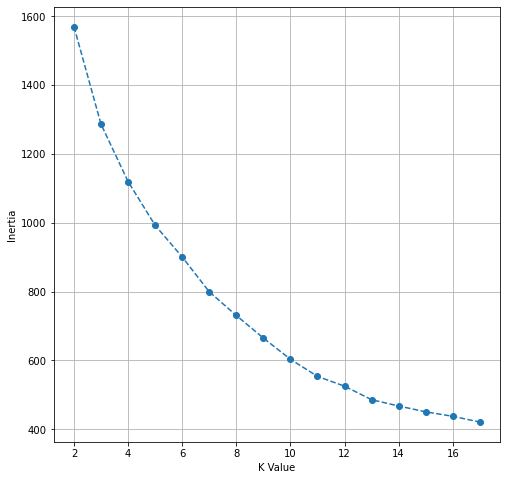

In [671]:
K=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
inertia=[KMeans(n_clusters=i).fit(df_pca).inertia_ for i in K]
plt.plot(K,inertia,'o--')
plt.xlabel('K Value')
plt.ylabel('Inertia')
plt.grid()
plt.show()

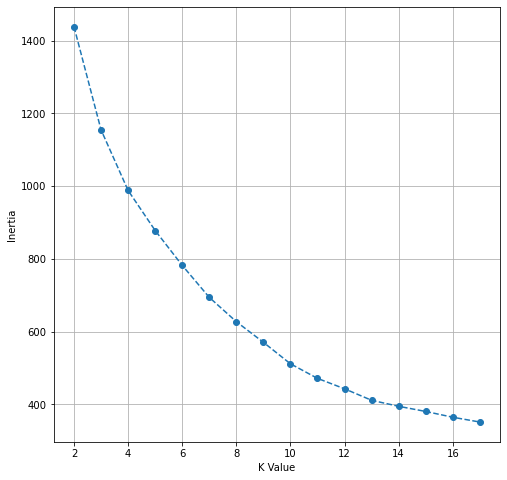

In [672]:
K=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
inertia=[KMeans(n_clusters=i).fit(df_pca2).inertia_ for i in K]
plt.plot(K,inertia,'o--')
plt.xlabel('K Value')
plt.ylabel('Inertia')
plt.grid()
plt.show()

> The one with 5 dimensions PCA has the lower inertia.

> Now, we count the silhouette score of each type of K-means

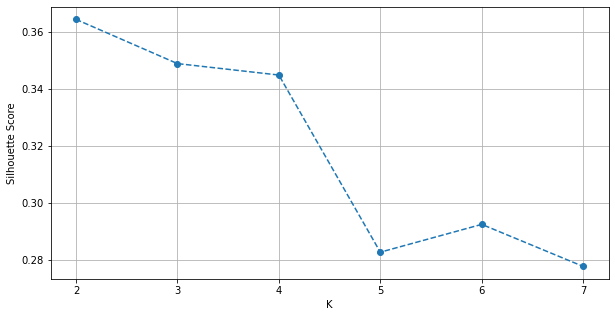

In [674]:
K=[2,3,4,5,6,7]
s_score_slc=[silhouette_score(df_scaled, KMeans(n_clusters=i).fit(df_scaled).labels_) for i in K]
plt.figure(figsize=(10,5))
plt.plot(K,s_score_slc,'o--')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

> The one with no PCA

For n_clusters = 2 The average silhouette_score is : 0.36426044124088114
For n_clusters = 3 The average silhouette_score is : 0.3488667700973527
For n_clusters = 4 The average silhouette_score is : 0.3447661080332832
For n_clusters = 5 The average silhouette_score is : 0.282565822136872
For n_clusters = 6 The average silhouette_score is : 0.29246769671198974
For n_clusters = 7 The average silhouette_score is : 0.308383595062719


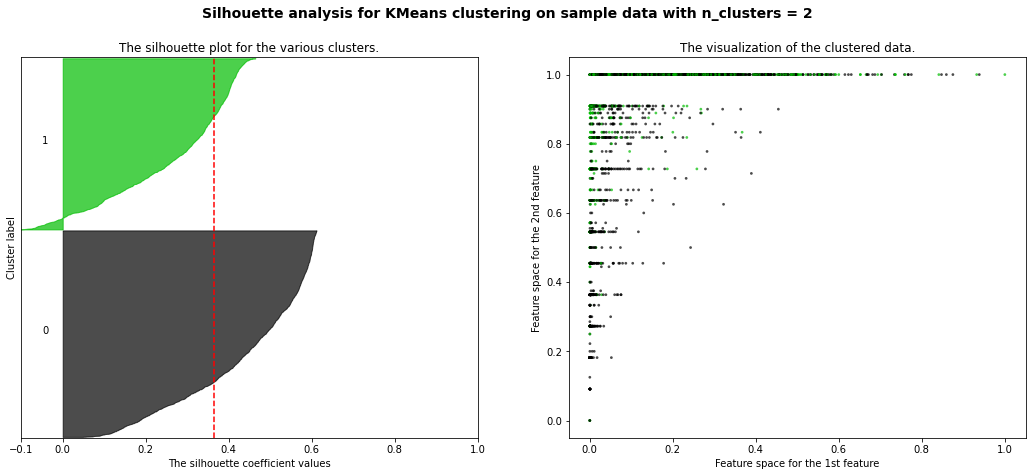

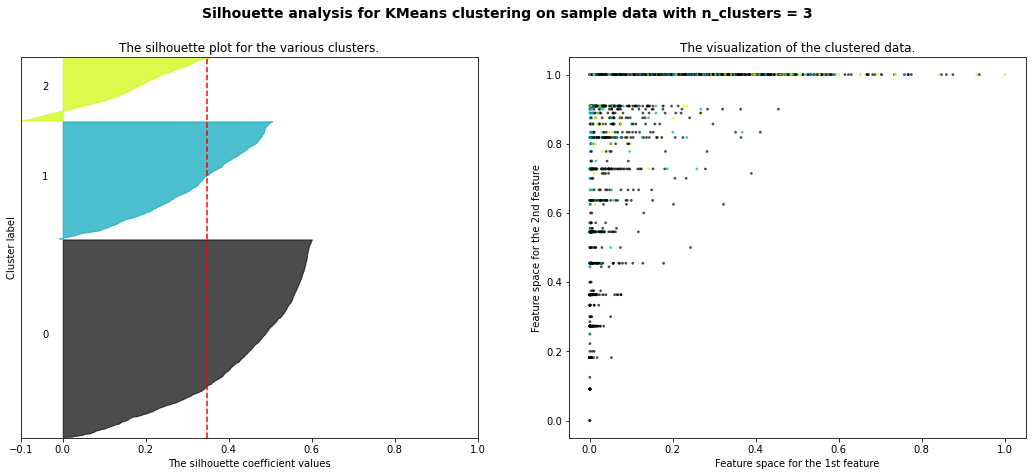

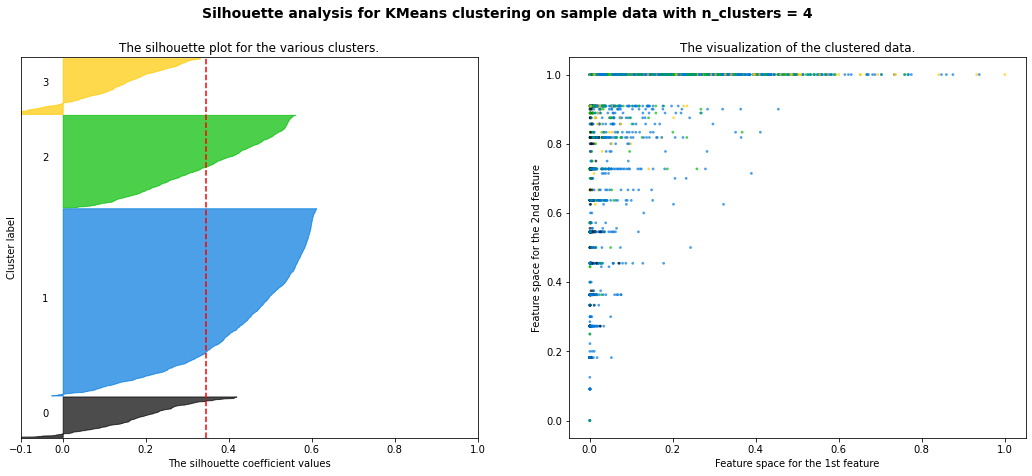

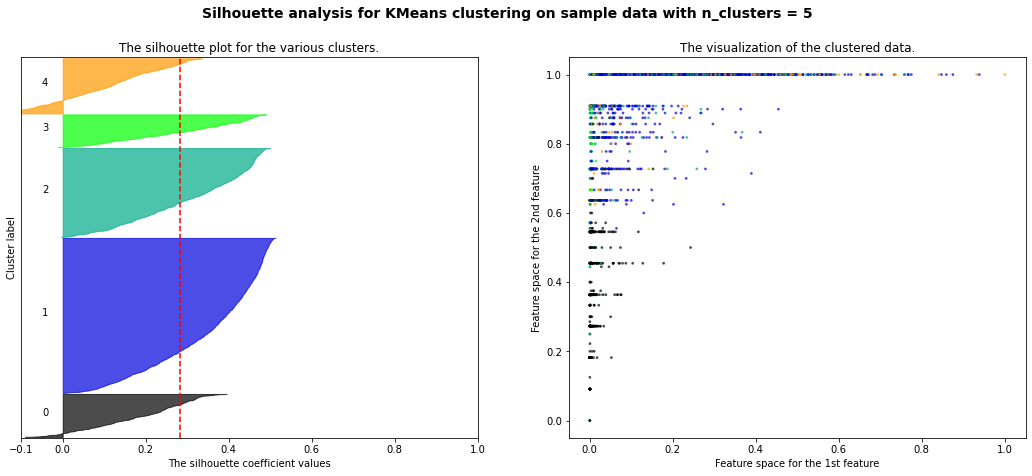

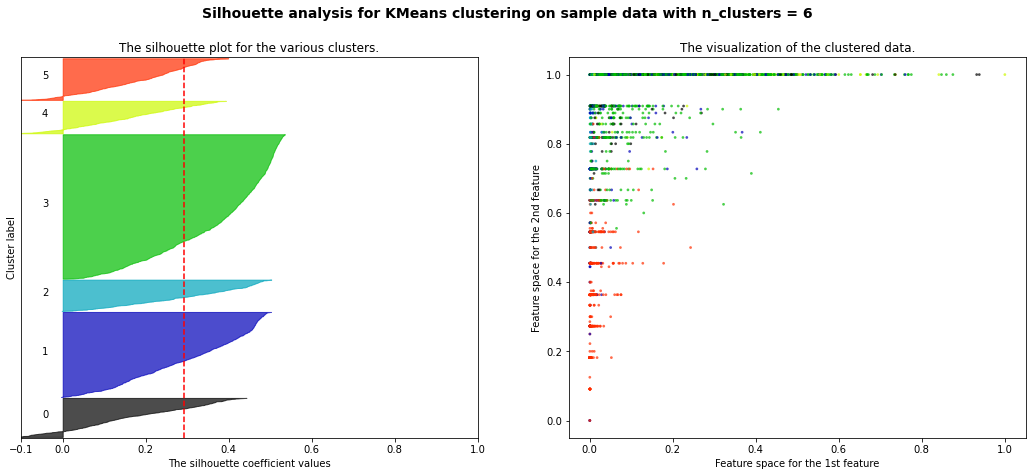

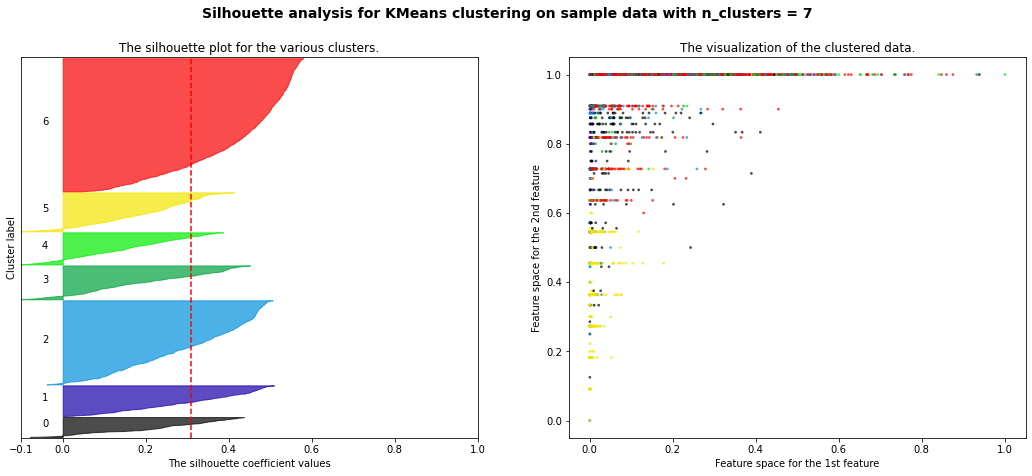

In [675]:
plot_silhouette(KMeans,K,df_scaled,'KMeans')

> The one with 90% of information

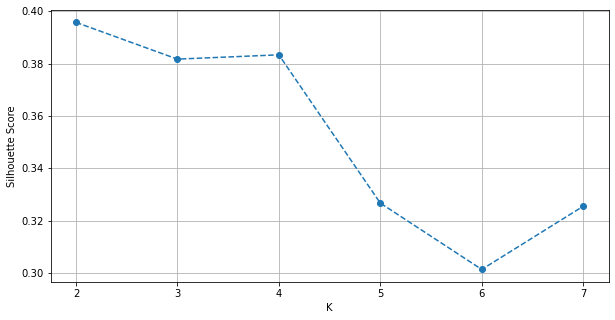

In [676]:
K=[2,3,4,5,6,7]
s_score_slc=[silhouette_score(df_pca, KMeans(n_clusters=i).fit(df_pca).labels_) for i in K]
plt.figure(figsize=(10,5))
plt.plot(K,s_score_slc,'o--')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3957031862255051
For n_clusters = 3 The average silhouette_score is : 0.38169196653486354
For n_clusters = 4 The average silhouette_score is : 0.383314295874502
For n_clusters = 5 The average silhouette_score is : 0.32676646793481257
For n_clusters = 6 The average silhouette_score is : 0.3448167123981827
For n_clusters = 7 The average silhouette_score is : 0.35041086245197917


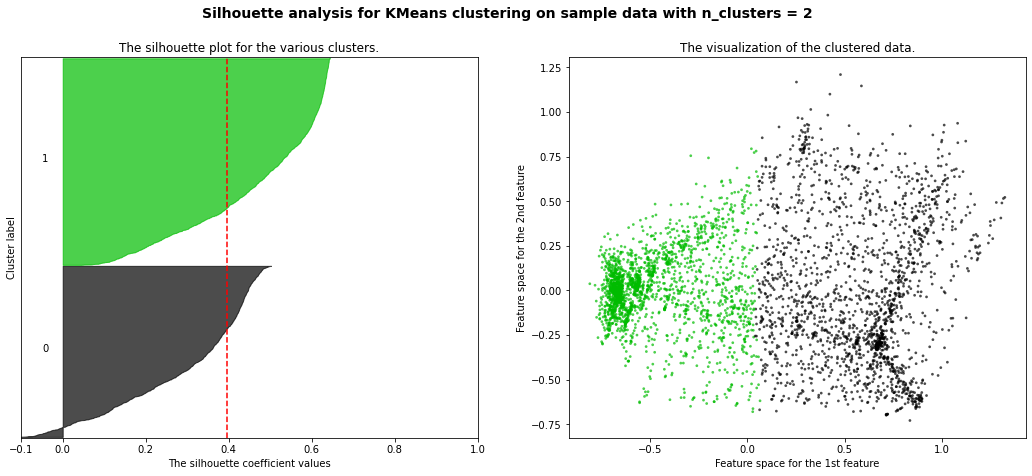

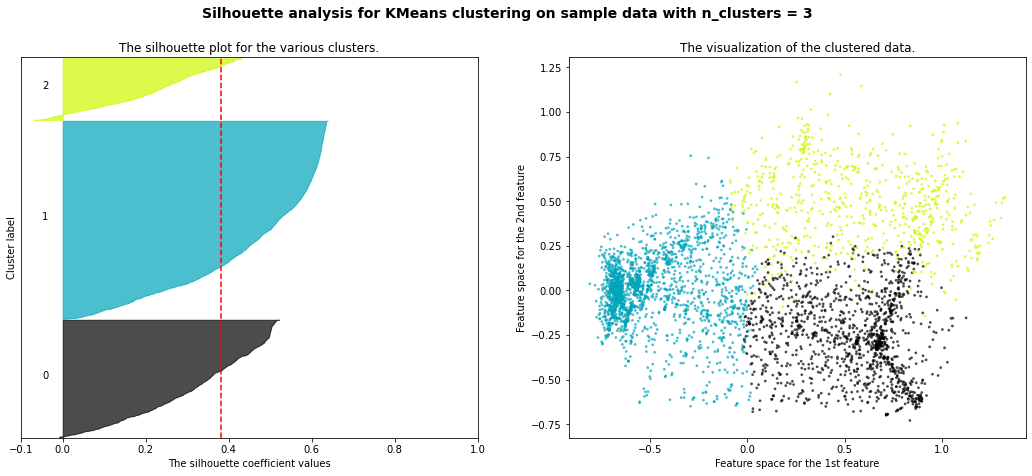

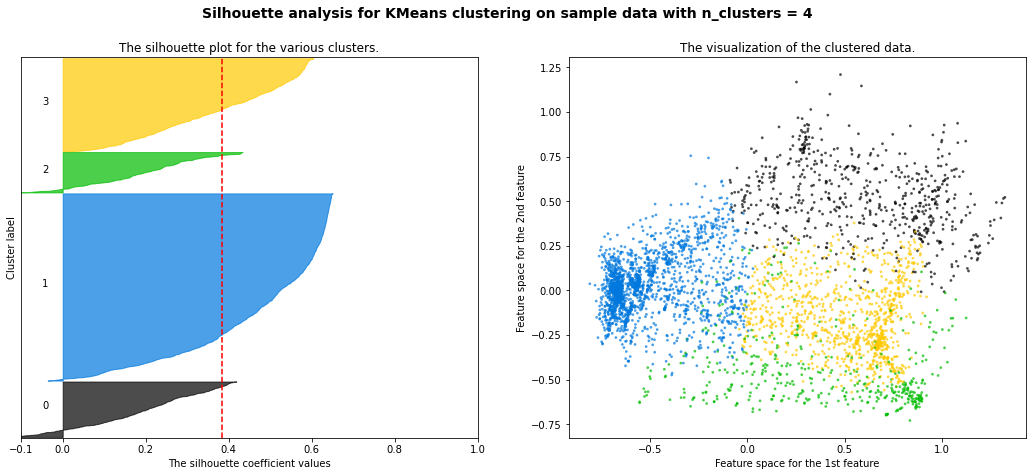

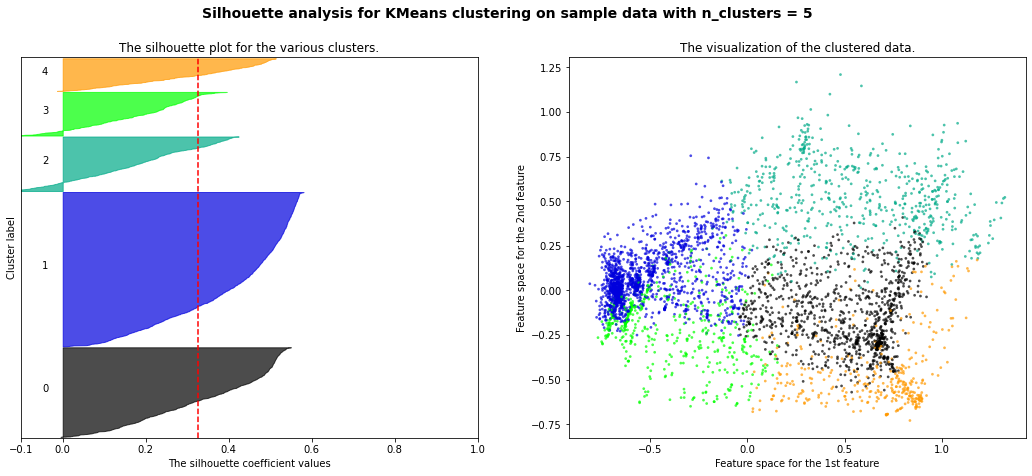

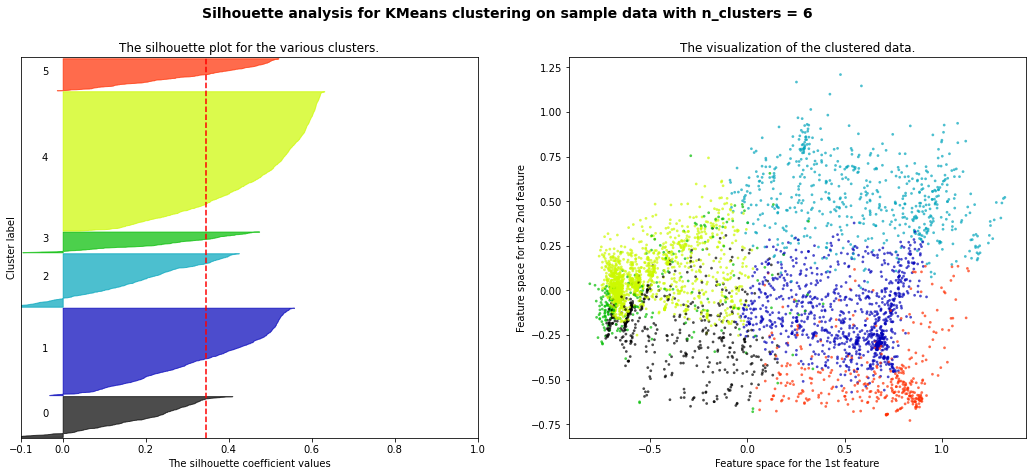

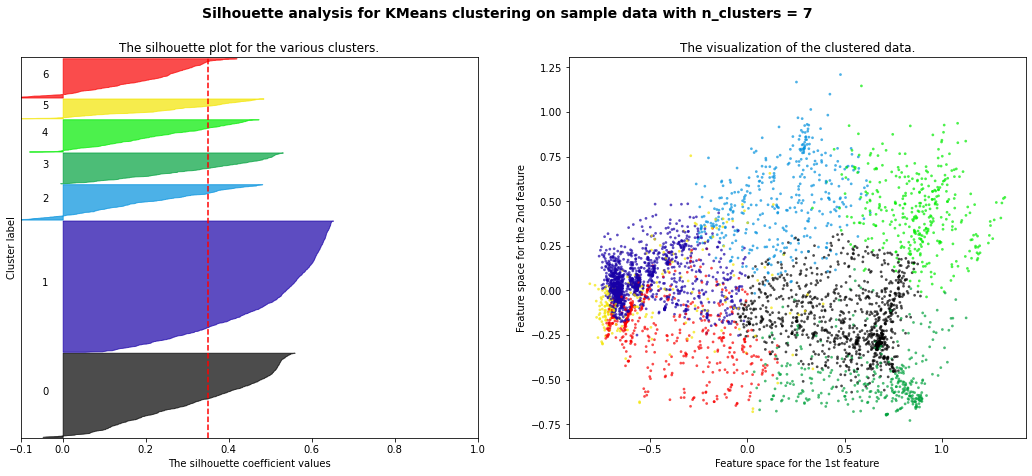

In [677]:
plot_silhouette(KMeans,K,df_pca,'KMeans')

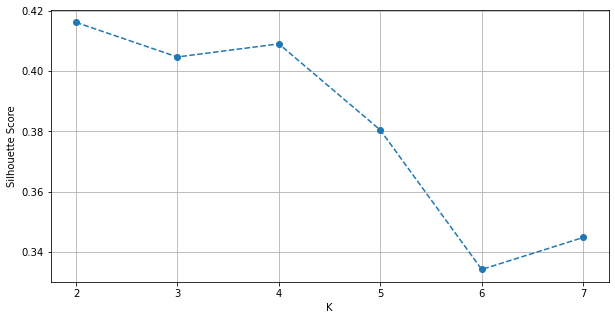

In [678]:
K=[2,3,4,5,6,7]
s_score_slc=[silhouette_score(df_pca2, KMeans(n_clusters=i).fit(df_pca2).labels_) for i in K]
plt.figure(figsize=(10,5))
plt.plot(K,s_score_slc,'o--')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

> The one with 5 dimensions PCA:

For n_clusters = 2 The average silhouette_score is : 0.41617329802908215
For n_clusters = 3 The average silhouette_score is : 0.4046987882308889
For n_clusters = 4 The average silhouette_score is : 0.40899817157298574
For n_clusters = 5 The average silhouette_score is : 0.380307845726422
For n_clusters = 6 The average silhouette_score is : 0.3283968175558146
For n_clusters = 7 The average silhouette_score is : 0.34431082851907335


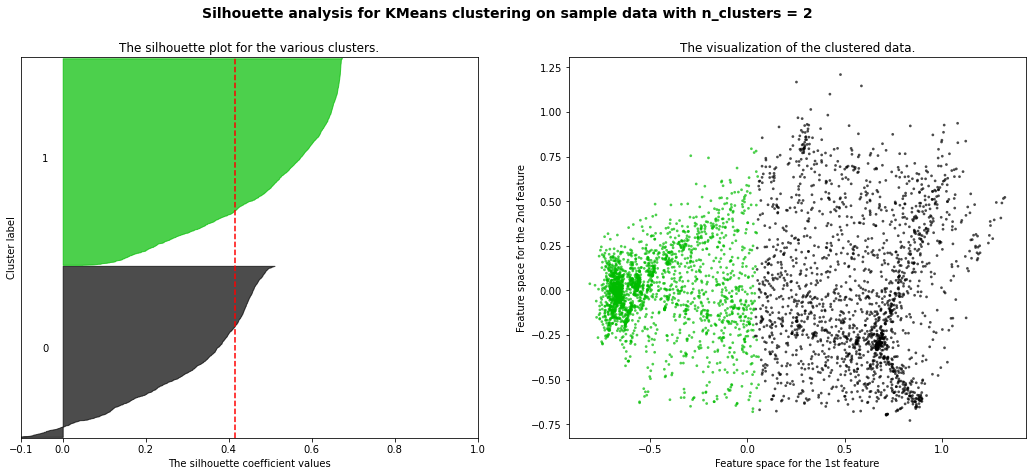

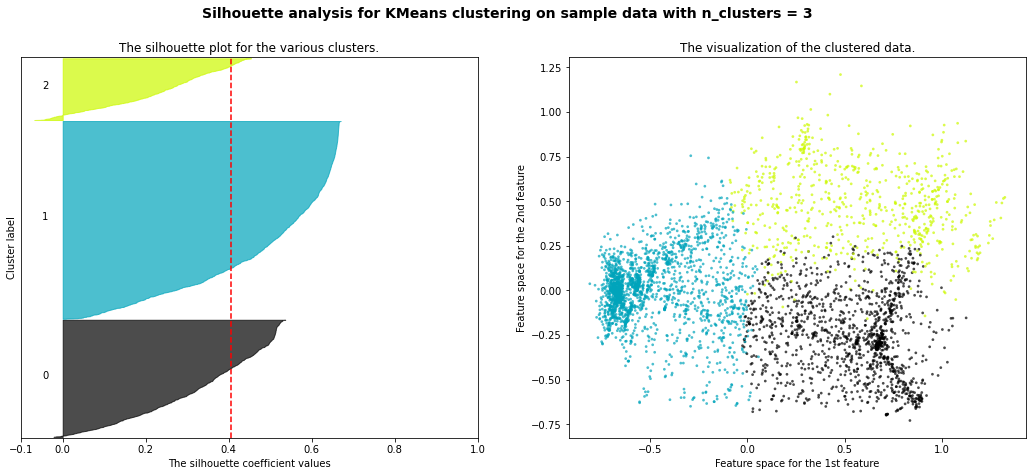

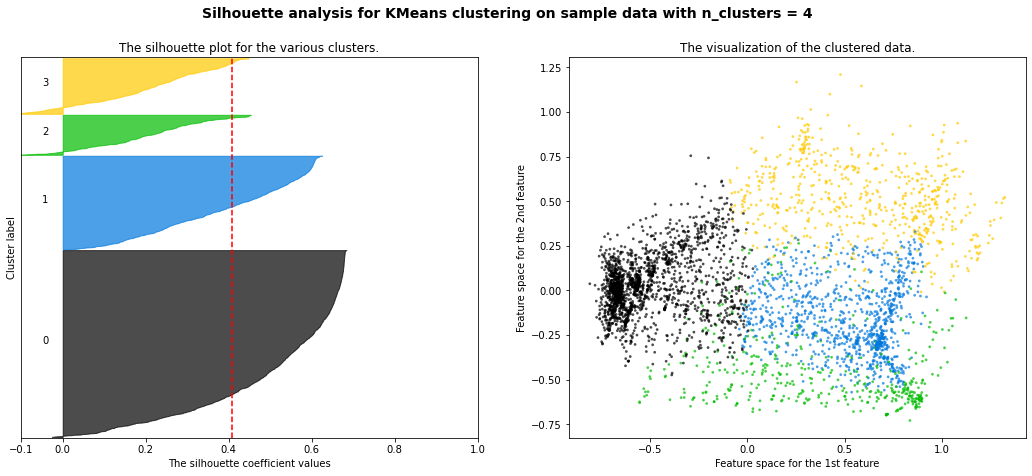

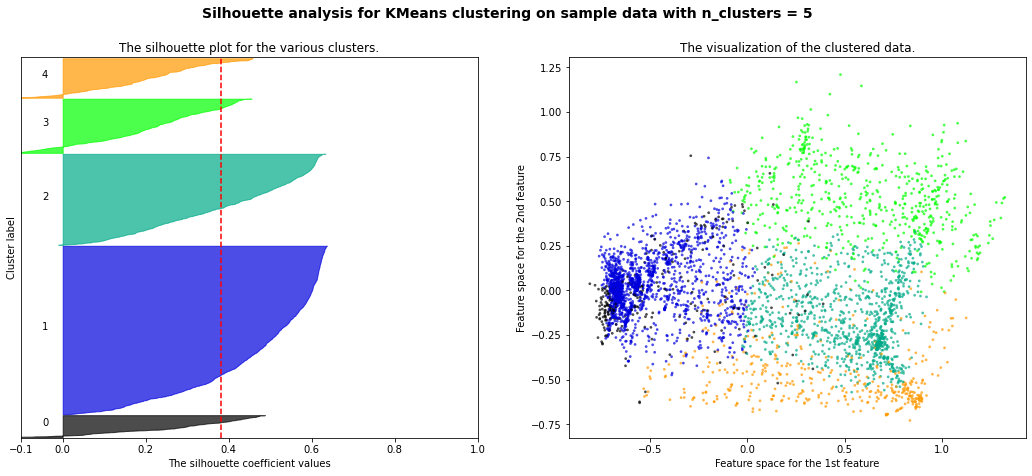

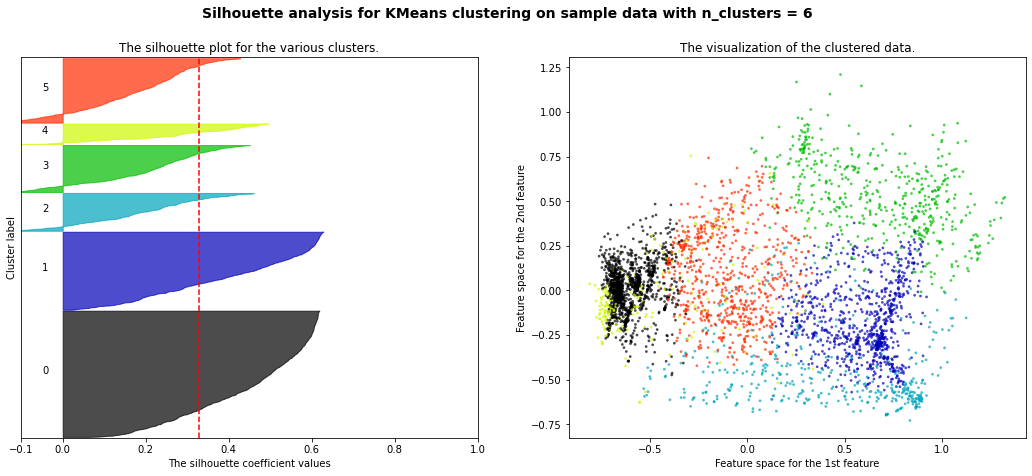

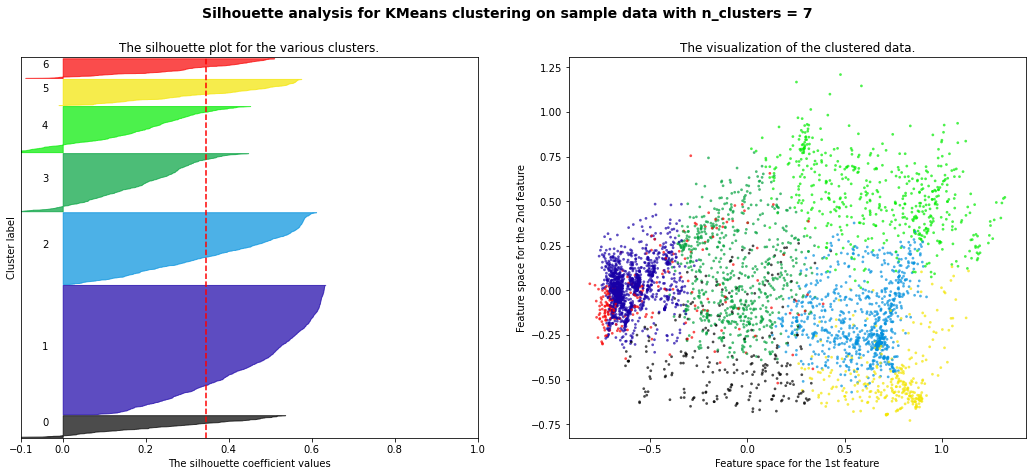

In [679]:
plot_silhouette(KMeans,K,df_pca2,'KMeans')

> The best result seems to be with 5 dimension (With KneeLocator), and 2 clusters with the score `0.41`

### **7. 1. 2. Model Testing (K-Means)**

> Testing with 'lloyd'/'auto' algorithm

In [680]:
kmn =  KMeans(algorithm='auto', n_clusters=2)
km = kmn.fit(df_pca2)
df_comp = df.copy()
df_comp['k-means_auto'] = km.labels_
df_comp


balance  balance_frequency  purchases  oneoff_purchases  \
1      943.584041           0.875000     103.00            103.00   
3      461.455720           1.000000     585.00            585.00   
4     1053.594730           1.000000    1450.00           1450.00   
5     2237.238086           1.000000     120.00            120.00   
7      424.994385           0.375000    1200.00           1200.00   
...           ...                ...        ...               ...   
4470  1079.008102           1.000000       0.00              0.00   
4471   809.582978           0.909091       0.00              0.00   
4472  3386.490883           1.000000     560.98            427.22   
4473  4840.545574           1.000000    1595.93           1595.93   
4474  1977.007090           1.000000    1032.04            226.90   

      installments_purchases  cash_advance  purchases_frequency  \
1                       0.00      0.000000             0.125000   
3                       0.00      0.000000             0.125000   
4                       0.00      0.000000             0.125000   
5                       0.00      0.000000             0.125000   
7                       0.00      0.000000             0.125000   
...                      ...           ...                  ...   
4470                    0.00   1259.571764             0.000000   
4471                    0.00   3819.672466             0.000000   
4472                  133.76   2008.153534             1.000000   
4473                    0.00   4359.325750             0.454545   
4474                  805.14   4335.919227             0.909091   

      oneoff_purchases_frequency  purchases_installments_frequency  \
1                       0.125000                          0.000000   
3                       0.125000                          0.000000   
4                       0.125000                          0.000000   
5                       0.125000                          0.000000   
7                       0.125000                          0.000000   
...                          ...                               ...   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.727273                          0.363636   
4473                    0.454545                          0.000000   
4474                    0.090909                          0.818182   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
1                   0.000000                 0              1        1000.0   
3                   0.000000                 0              1        1000.0   
4                   0.000000                 0              1        1500.0   
5                   0.000000                 0              1        2500.0   
7                   0.000000                 0              1        1200.0   
...                      ...               ...            ...           ...   
4470                0.545455                 9              0        1200.0   
4471                0.545455                 7              0        4150.0   
4472                0.545455                 9             20       10100.0   
4473                0.545455                17             25        6000.0   
4474                0.545455                21             17        4000.0   

         payments  minimum_payments  prc_full_payment  tenure  k-means_auto  
1      215.325023        410.484825          0.000000       8             1  
3      258.032630        151.696433          0.000000       8             1  
4      397.090516        227.143184          0.000000       8             1  
5      343.102984        712.986387          0.000000       8             1  
7       57.266292         56.720210          0.000000       8             1  
...           ...               ...               ...     ...           ...  
4470  1379.635287        271.364415     

> Testing with elkan algorithm

In [681]:
kmn2 =  KMeans(algorithm='elkan', n_clusters=2)
km2 = kmn2.fit(df_pca2)
df_comp['k-means_elkan'] = km2.labels_
df_comp

balance  balance_frequency  purchases  oneoff_purchases  \
1      943.584041           0.875000     103.00            103.00   
3      461.455720           1.000000     585.00            585.00   
4     1053.594730           1.000000    1450.00           1450.00   
5     2237.238086           1.000000     120.00            120.00   
7      424.994385           0.375000    1200.00           1200.00   
...           ...                ...        ...               ...   
4470  1079.008102           1.000000       0.00              0.00   
4471   809.582978           0.909091       0.00              0.00   
4472  3386.490883           1.000000     560.98            427.22   
4473  4840.545574           1.000000    1595.93           1595.93   
4474  1977.007090           1.000000    1032.04            226.90   

      installments_purchases  cash_advance  purchases_frequency  \
1                       0.00      0.000000             0.125000   
3                       0.00      0.000000             0.125000   
4                       0.00      0.000000             0.125000   
5                       0.00      0.000000             0.125000   
7                       0.00      0.000000             0.125000   
...                      ...           ...                  ...   
4470                    0.00   1259.571764             0.000000   
4471                    0.00   3819.672466             0.000000   
4472                  133.76   2008.153534             1.000000   
4473                    0.00   4359.325750             0.454545   
4474                  805.14   4335.919227             0.909091   

      oneoff_purchases_frequency  purchases_installments_frequency  \
1                       0.125000                          0.000000   
3                       0.125000                          0.000000   
4                       0.125000                          0.000000   
5                       0.125000                          0.000000   
7                       0.125000                          0.000000   
...                          ...                               ...   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.727273                          0.363636   
4473                    0.454545                          0.000000   
4474                    0.090909                          0.818182   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
1                   0.000000                 0              1        1000.0   
3                   0.000000                 0              1        1000.0   
4                   0.000000                 0              1        1500.0   
5                   0.000000                 0              1        2500.0   
7                   0.000000                 0              1        1200.0   
...                      ...               ...            ...           ...   
4470                0.545455                 9              0        1200.0   
4471                0.545455                 7              0        4150.0   
4472                0.545455                 9             20       10100.0   
4473                0.545455                17             25        6000.0   
4474                0.545455                21             17        4000.0   

         payments  minimum_payments  prc_full_payment  tenure  k-means_auto  \
1      215.325023        410.484825          0.000000       8             1   
3      258.032630        151.696433          0.000000       8             1   
4      397.090516        227.143184          0.000000       8             1   
5      343.102984        712.986387          0.000000       8             1   
7       57.266292         56.720210          0.000000       8             1   
...           ...               ...               ...     ...           ...   
4470  1379.635287        271.3644

> Saving this dataframe for future comparison and EDA. Now let's proceed to the second model, Spectral Clustering.

## **7. 2. Spectral Clustering**

### **Model Definition**

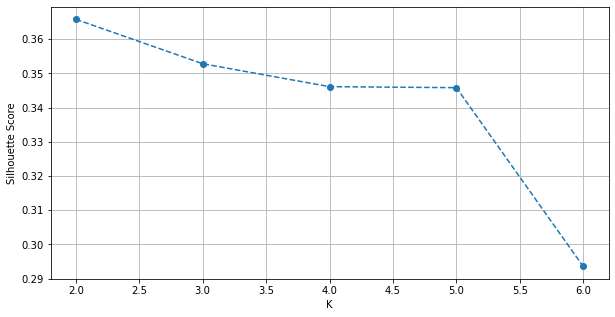

In [682]:
K=[2,3,4,5,6]
s_score_slc=[silhouette_score(df_scaled, SpectralClustering(n_clusters=i).fit(df_scaled).labels_) for i in K]
plt.figure(figsize=(10,5))
plt.plot(K,s_score_slc,'o--')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

> Trying the model with no-PCA data

For n_clusters = 2 The average silhouette_score is : 0.3657887024337583
For n_clusters = 3 The average silhouette_score is : 0.35281328781314997
For n_clusters = 4 The average silhouette_score is : 0.34611546052749254
For n_clusters = 5 The average silhouette_score is : 0.3456618794100934
For n_clusters = 6 The average silhouette_score is : 0.29360896290394695


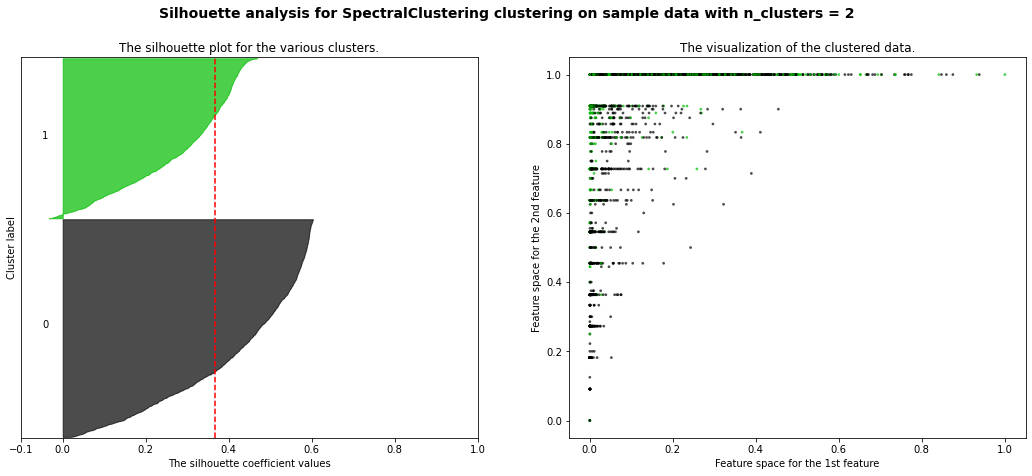

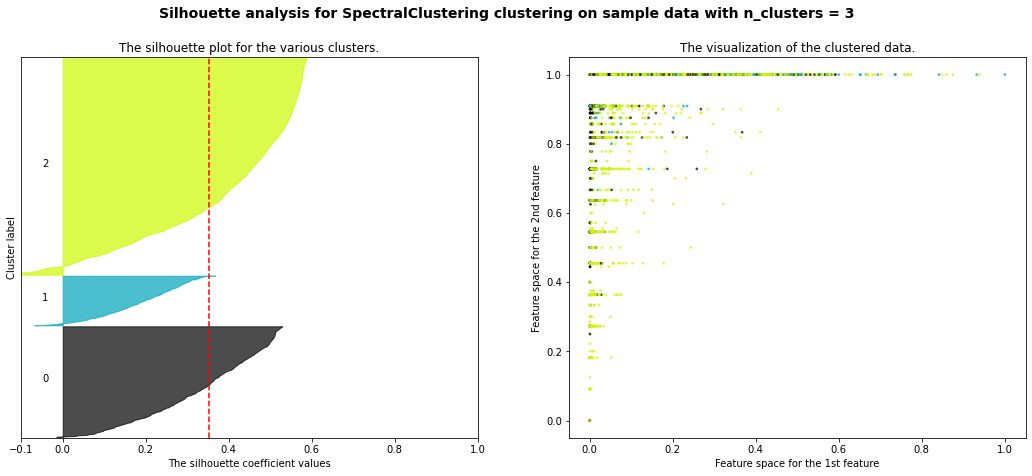

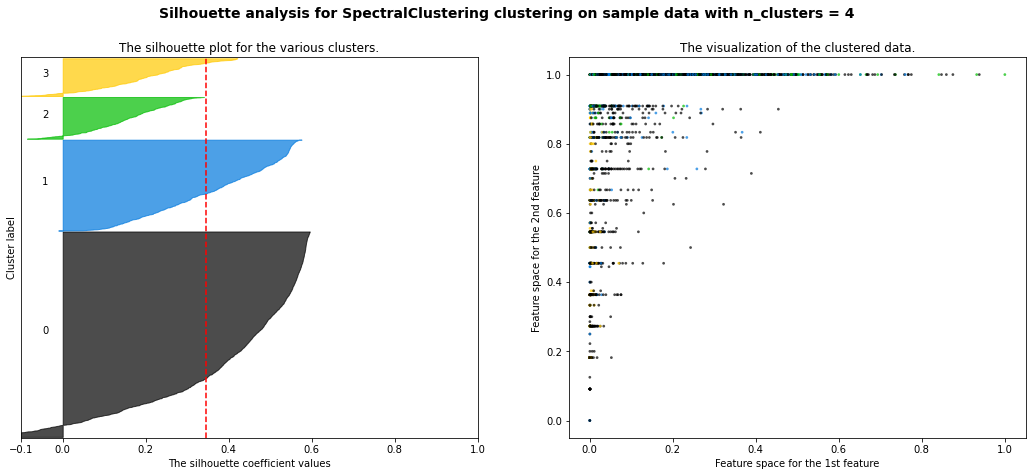

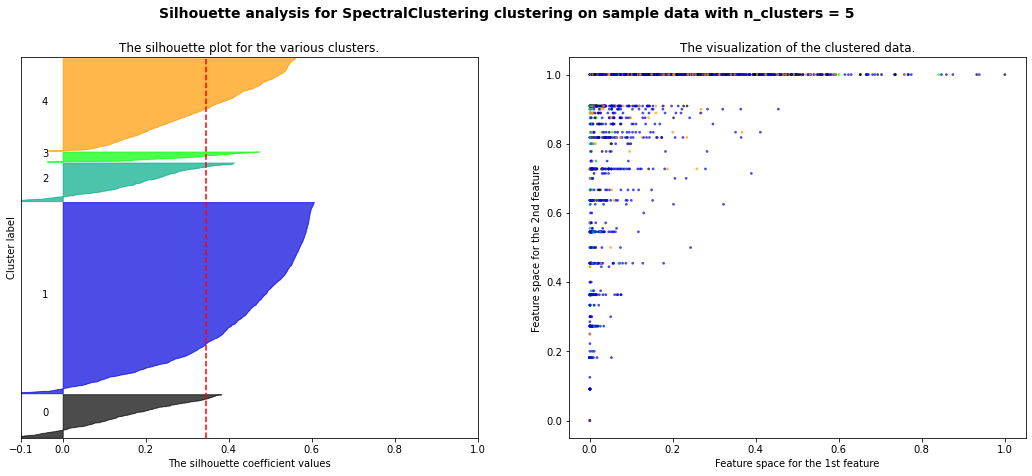

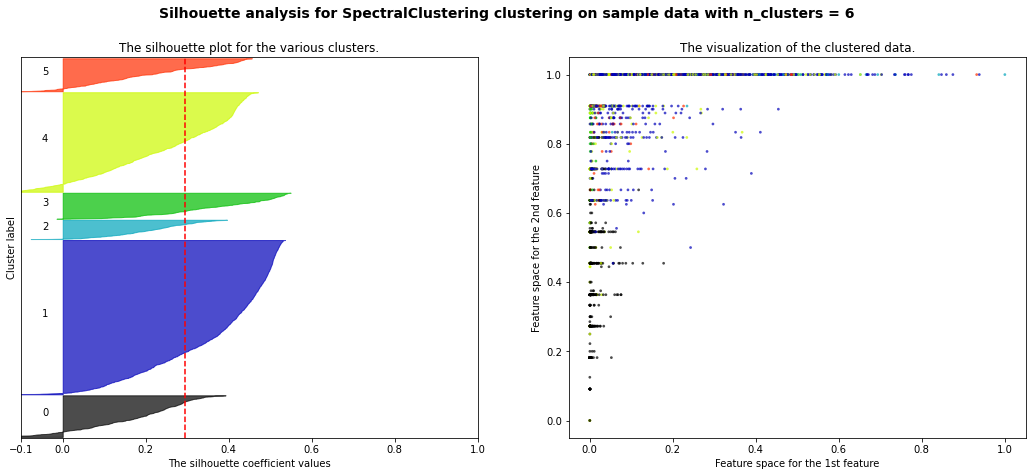

In [683]:
plot_silhouette(SpectralClustering,K,df_scaled,'SpectralClustering')

> Trying the model with PCA 90% of information (6 dimension)

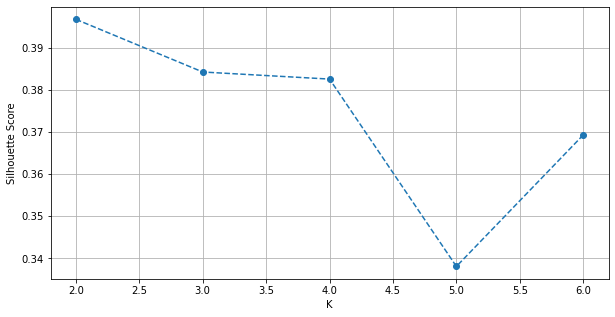

In [684]:
K=[2,3,4,5,6]
s_score_slc=[silhouette_score(df_pca, SpectralClustering(n_clusters=i).fit(df_pca).labels_) for i in K]
plt.figure(figsize=(10,5))
plt.plot(K,s_score_slc,'o--')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

> The one with 90% information PCA

For n_clusters = 2 The average silhouette_score is : 0.3967685855820218
For n_clusters = 3 The average silhouette_score is : 0.3842637488947674
For n_clusters = 4 The average silhouette_score is : 0.3825815494244222
For n_clusters = 5 The average silhouette_score is : 0.33808214709408785
For n_clusters = 6 The average silhouette_score is : 0.3490235204840712


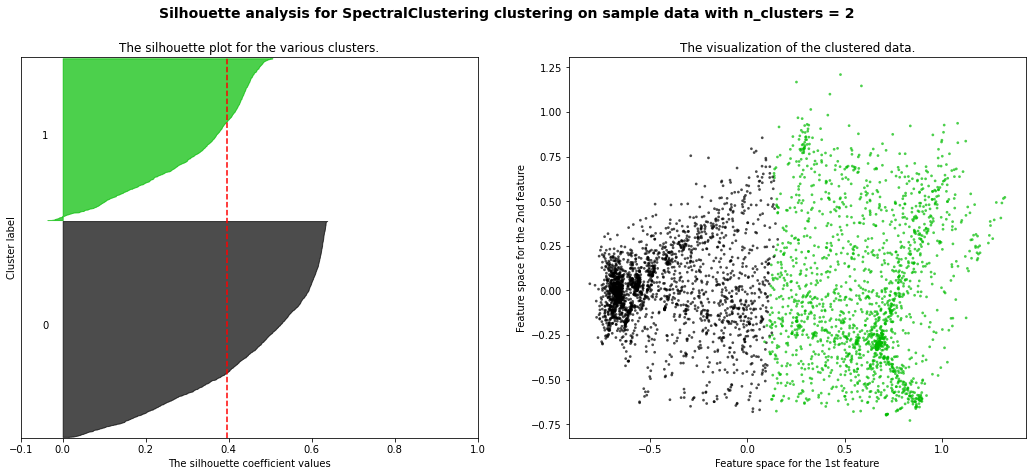

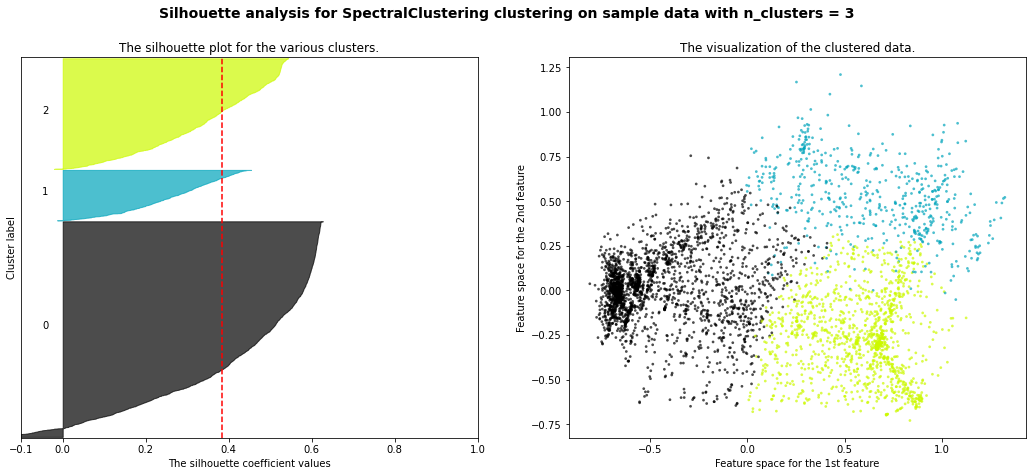

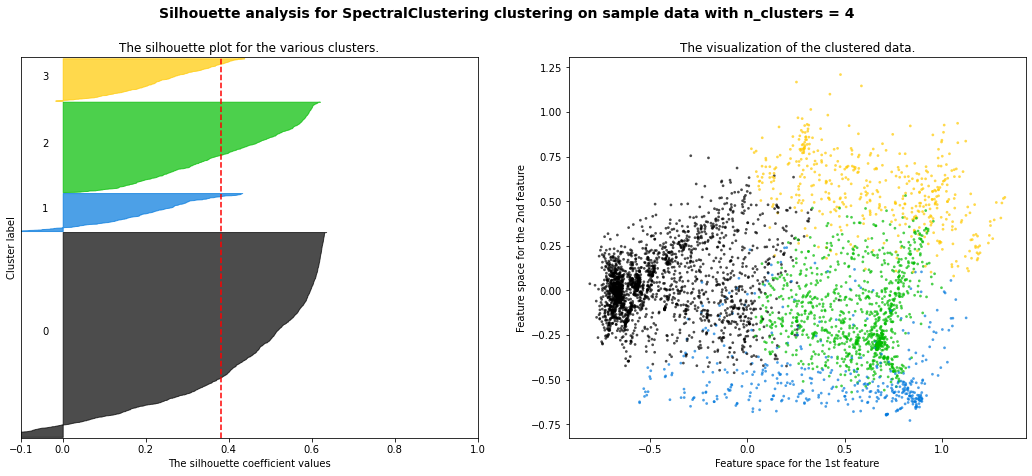

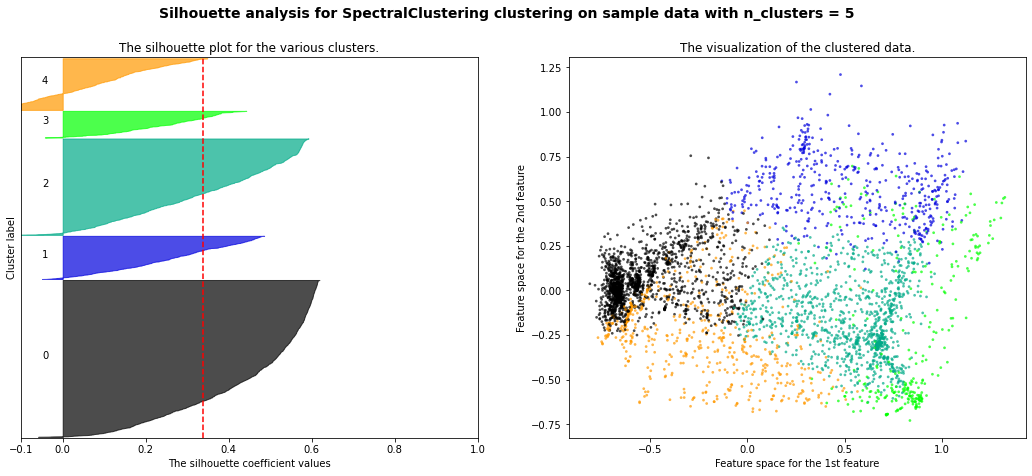

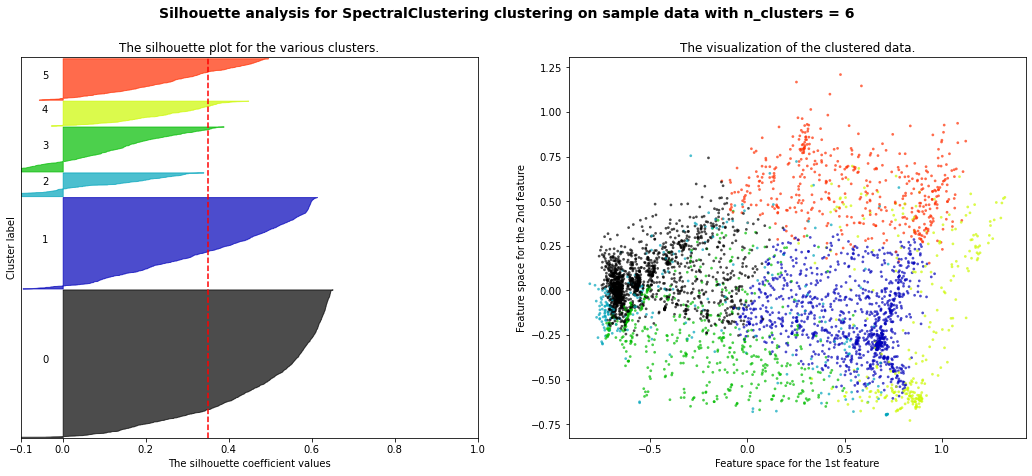

In [685]:
plot_silhouette(SpectralClustering,K,df_pca,'SpectralClustering')

> Now we try the PCA'd data with 5 dimension

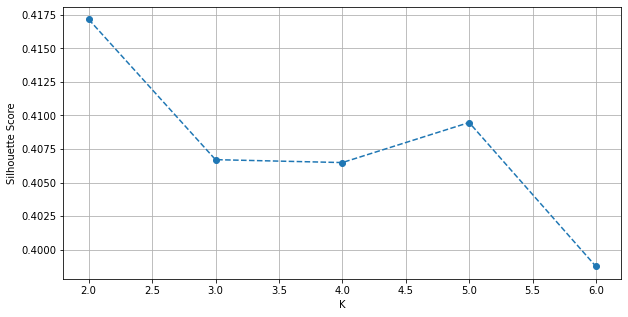

In [686]:
K=[2,3,4,5,6]
s_score_slc=[silhouette_score(df_pca2, SpectralClustering(n_clusters=i).fit(df_pca2).labels_) for i in K]
plt.figure(figsize=(10,5))
plt.plot(K,s_score_slc,'o--')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.4171576606327812
For n_clusters = 3 The average silhouette_score is : 0.40671151411022377
For n_clusters = 4 The average silhouette_score is : 0.40649459372025615
For n_clusters = 5 The average silhouette_score is : 0.409486978787069
For n_clusters = 6 The average silhouette_score is : 0.398790865483138


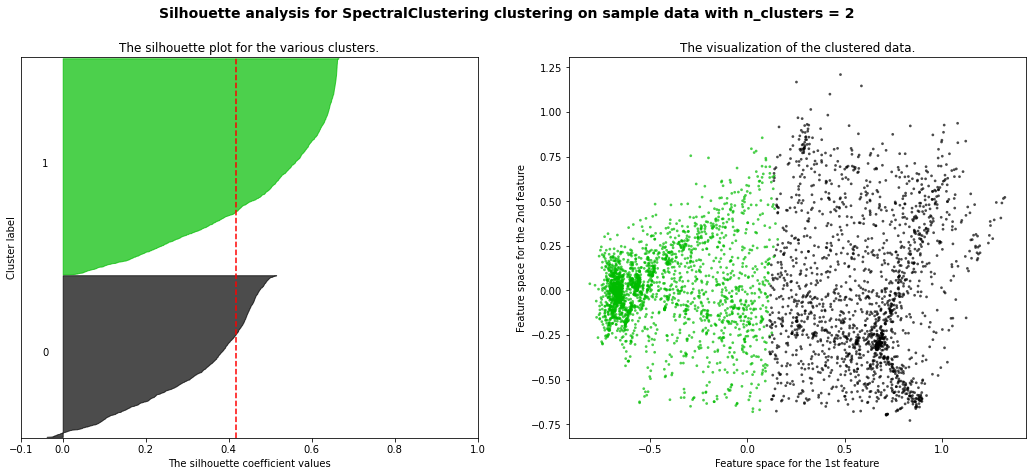

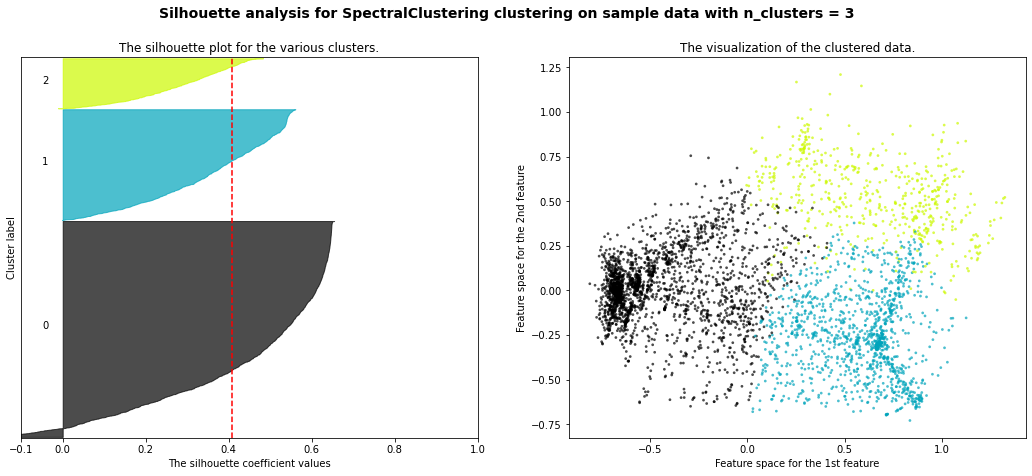

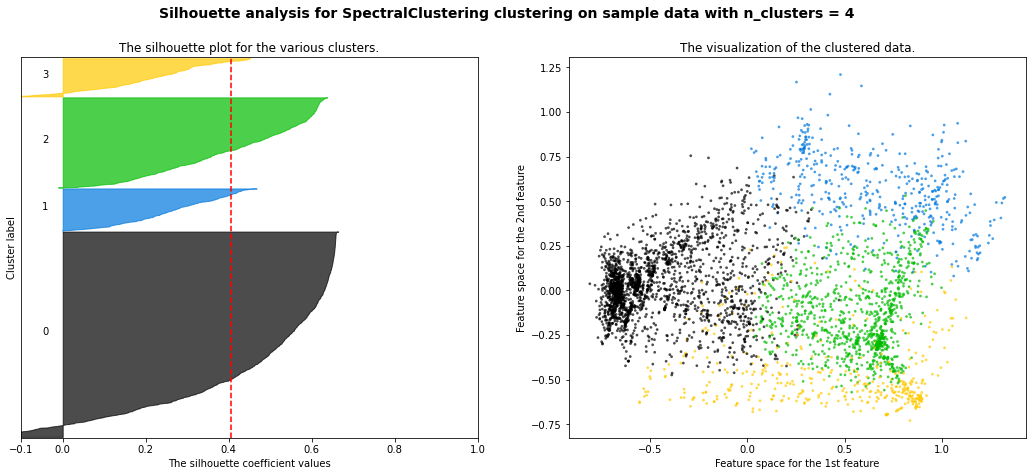

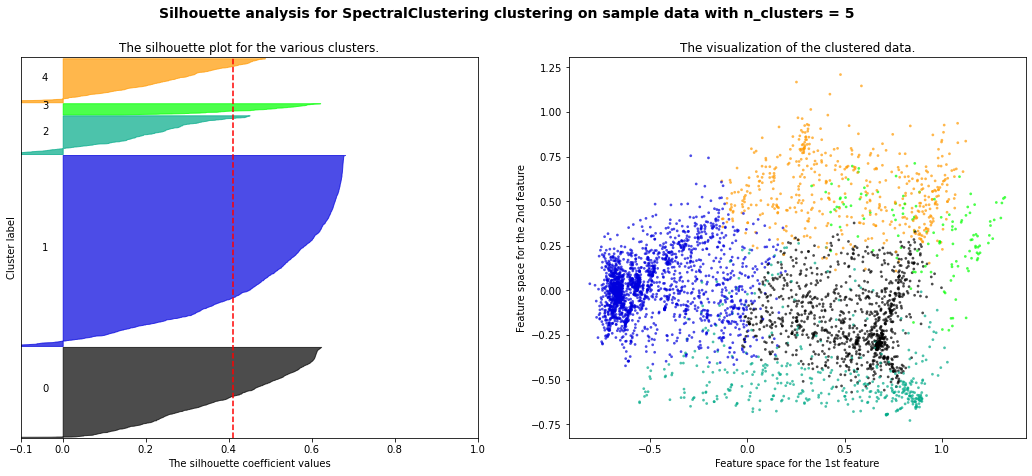

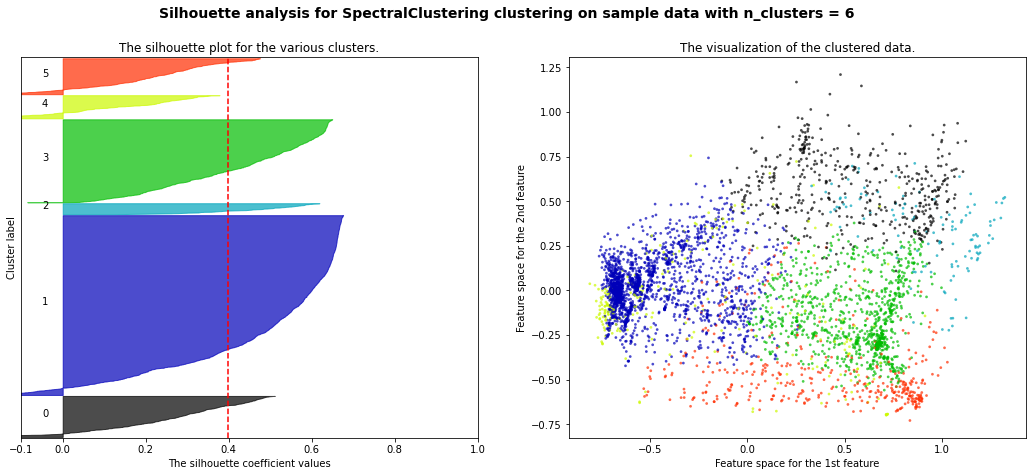

In [687]:
plot_silhouette(SpectralClustering, K, df_pca2, 'SpectralClustering')

> The one with 5 dimension PCA is the one with better sillhouette score with ncluster = 2. However, the scatter plot distribution looks similar to the K-Means with 2 ncluster. For experiment purposes, we will choose ncluster = 3 for Spectral Clustering to be tested.

In [688]:
spectral = SpectralClustering(n_clusters=3)
df_comp['spectral'] = spectral.fit_predict(df_scaled)
df_comp

balance  balance_frequency  purchases  oneoff_purchases  \
1      943.584041           0.875000     103.00            103.00   
3      461.455720           1.000000     585.00            585.00   
4     1053.594730           1.000000    1450.00           1450.00   
5     2237.238086           1.000000     120.00            120.00   
7      424.994385           0.375000    1200.00           1200.00   
...           ...                ...        ...               ...   
4470  1079.008102           1.000000       0.00              0.00   
4471   809.582978           0.909091       0.00              0.00   
4472  3386.490883           1.000000     560.98            427.22   
4473  4840.545574           1.000000    1595.93           1595.93   
4474  1977.007090           1.000000    1032.04            226.90   

      installments_purchases  cash_advance  purchases_frequency  \
1                       0.00      0.000000             0.125000   
3                       0.00      0.000000             0.125000   
4                       0.00      0.000000             0.125000   
5                       0.00      0.000000             0.125000   
7                       0.00      0.000000             0.125000   
...                      ...           ...                  ...   
4470                    0.00   1259.571764             0.000000   
4471                    0.00   3819.672466             0.000000   
4472                  133.76   2008.153534             1.000000   
4473                    0.00   4359.325750             0.454545   
4474                  805.14   4335.919227             0.909091   

      oneoff_purchases_frequency  purchases_installments_frequency  \
1                       0.125000                          0.000000   
3                       0.125000                          0.000000   
4                       0.125000                          0.000000   
5                       0.125000                          0.000000   
7                       0.125000                          0.000000   
...                          ...                               ...   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.727273                          0.363636   
4473                    0.454545                          0.000000   
4474                    0.090909                          0.818182   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
1                   0.000000                 0              1        1000.0   
3                   0.000000                 0              1        1000.0   
4                   0.000000                 0              1        1500.0   
5                   0.000000                 0              1        2500.0   
7                   0.000000                 0              1        1200.0   
...                      ...               ...            ...           ...   
4470                0.545455                 9              0        1200.0   
4471                0.545455                 7              0        4150.0   
4472                0.545455                 9             20       10100.0   
4473                0.545455                17             25        6000.0   
4474                0.545455                21             17        4000.0   

         payments  minimum_payments  prc_full_payment  tenure  k-means_auto  \
1      215.325023        410.484825          0.000000       8             1   
3      258.032630        151.696433          0.000000       8             1   
4      397.090516        227.143184          0.000000       8             1   
5      343.102984        712.986387          0.000000       8             1   
7       57.266292         56.720210          0.000000       8             1   
...           ...               ...               ...     ...           ...   
4470  1379.635287        271.3644

> Saving this dataframe for future EDA for comparison

> Proceeding to the next model: Agglomerative Clustering

## **7. 3. Agglomerative Clustering**

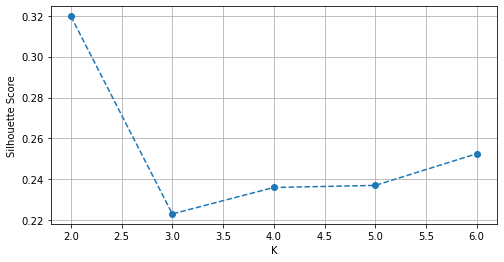

In [689]:
K=[2,3,4,5,6]
s_score_slc=[silhouette_score(df_scaled, AgglomerativeClustering(n_clusters=i).fit(df_scaled).labels_) for i in K]
plt.figure(figsize=(8,4))
plt.plot(K,s_score_slc,'o--')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

> No PCA Agglomerative

For n_clusters = 2 The average silhouette_score is : 0.31972115450228006
For n_clusters = 3 The average silhouette_score is : 0.22311509089895204
For n_clusters = 4 The average silhouette_score is : 0.23603757934373426
For n_clusters = 5 The average silhouette_score is : 0.23704368615011043
For n_clusters = 6 The average silhouette_score is : 0.25252052109500733


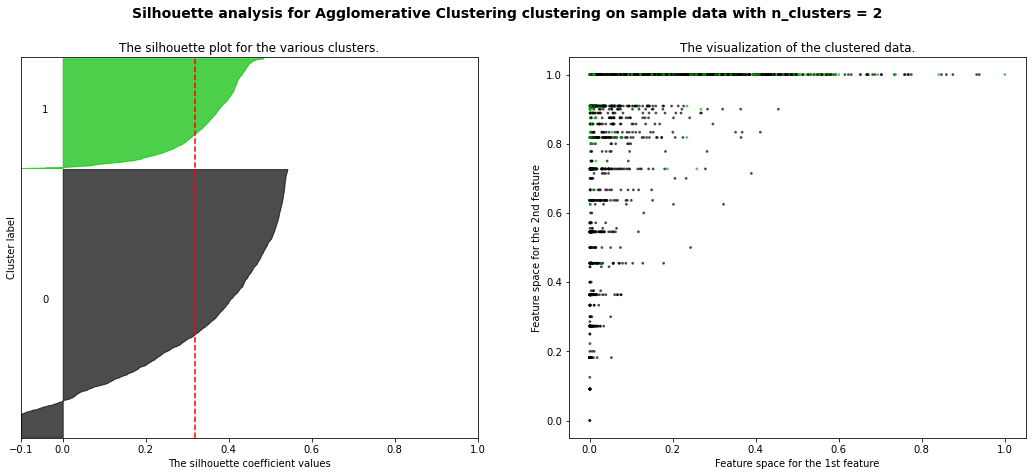

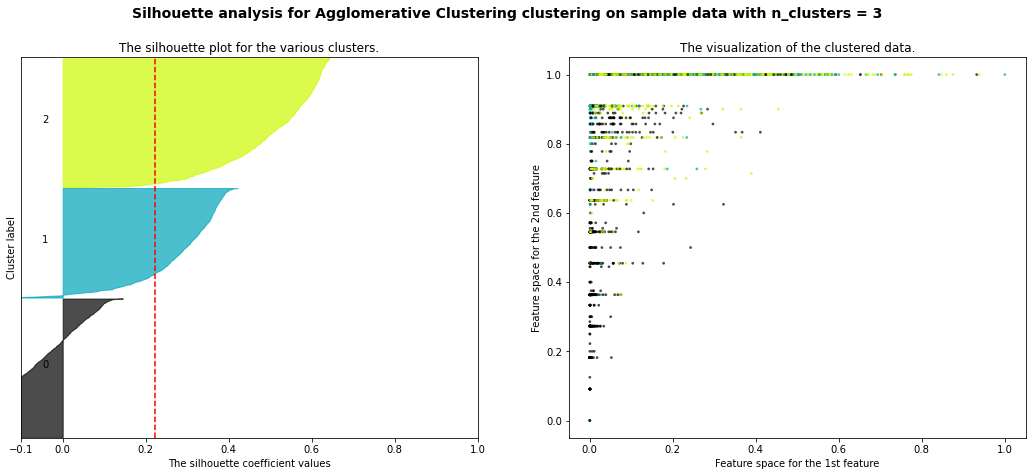

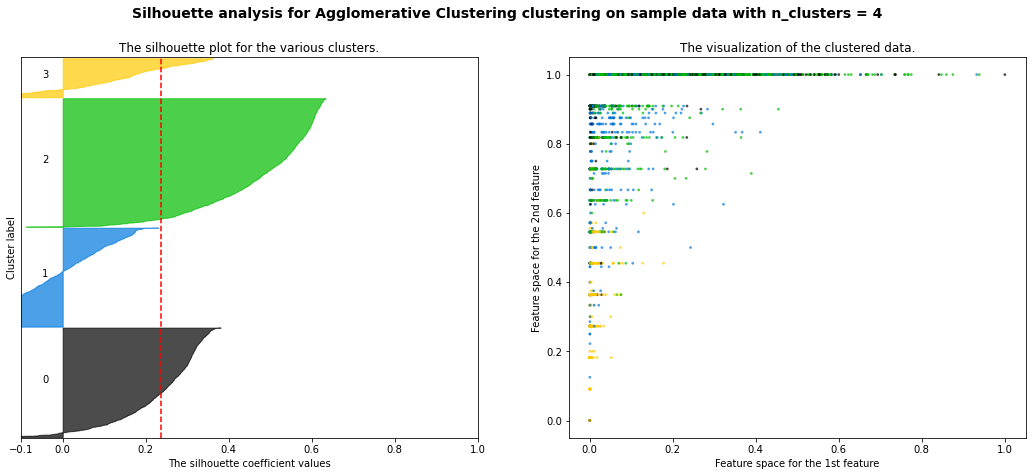

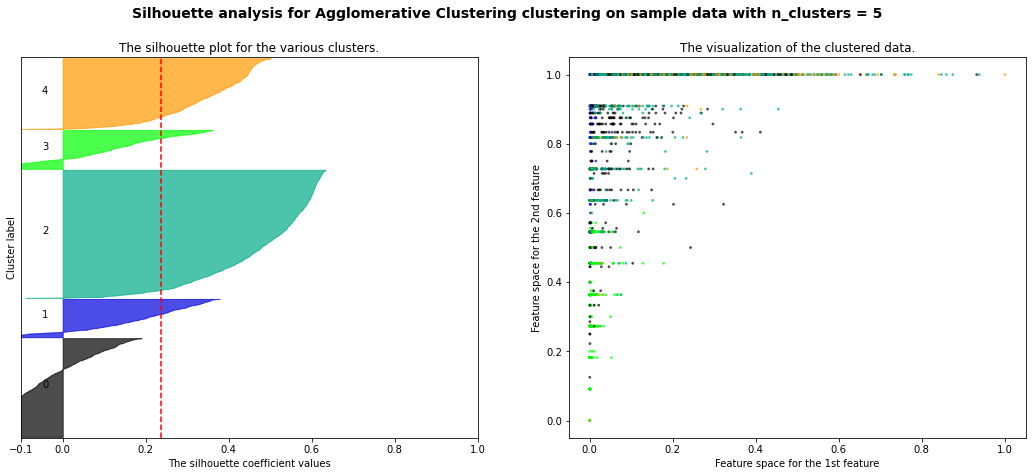

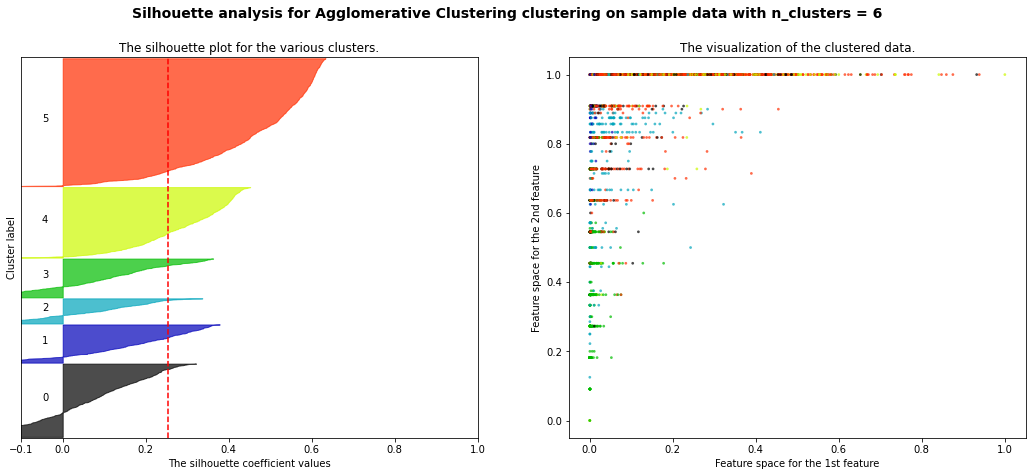

In [690]:
plot_silhouette(AgglomerativeClustering,K,df_scaled,'Agglomerative Clustering')

> 90% information agglomerative

For n_clusters = 2 The average silhouette_score is : 0.36304477747579517
For n_clusters = 3 The average silhouette_score is : 0.21834158470093595
For n_clusters = 4 The average silhouette_score is : 0.24770090566975028
For n_clusters = 5 The average silhouette_score is : 0.2540365097313009
For n_clusters = 6 The average silhouette_score is : 0.2771580174054036


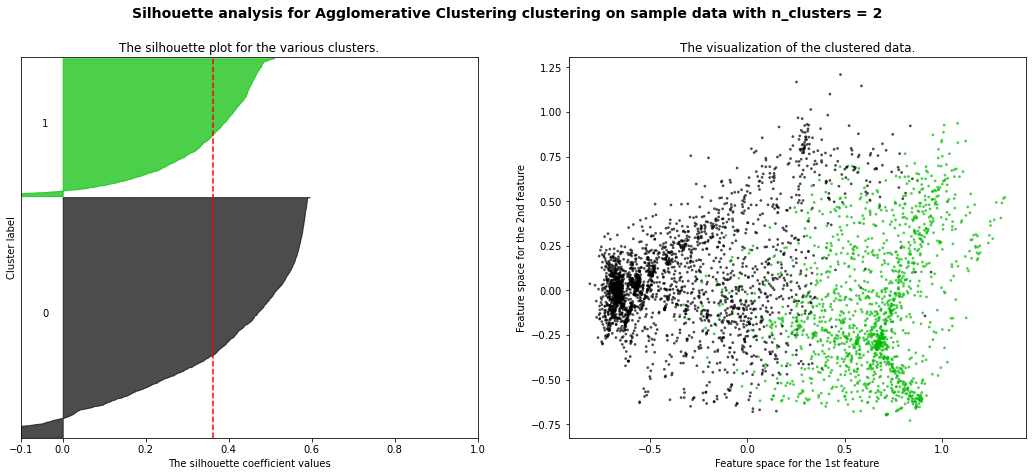

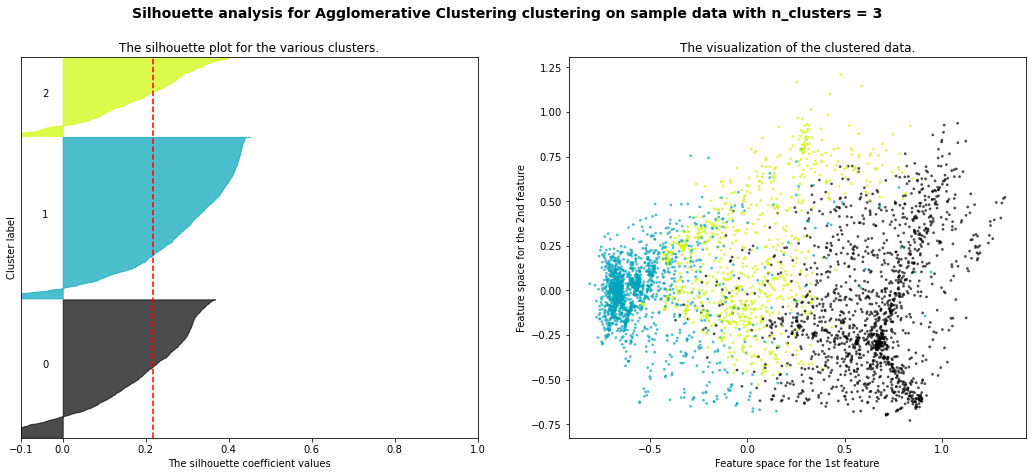

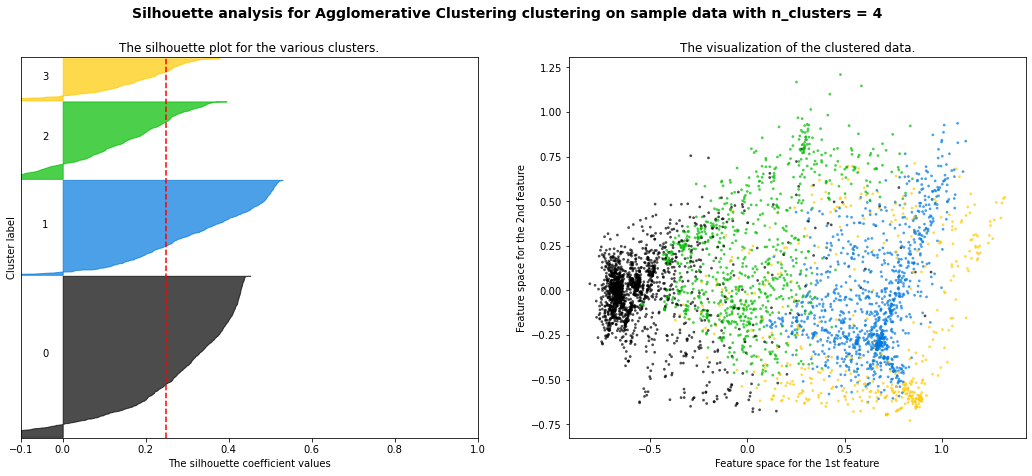

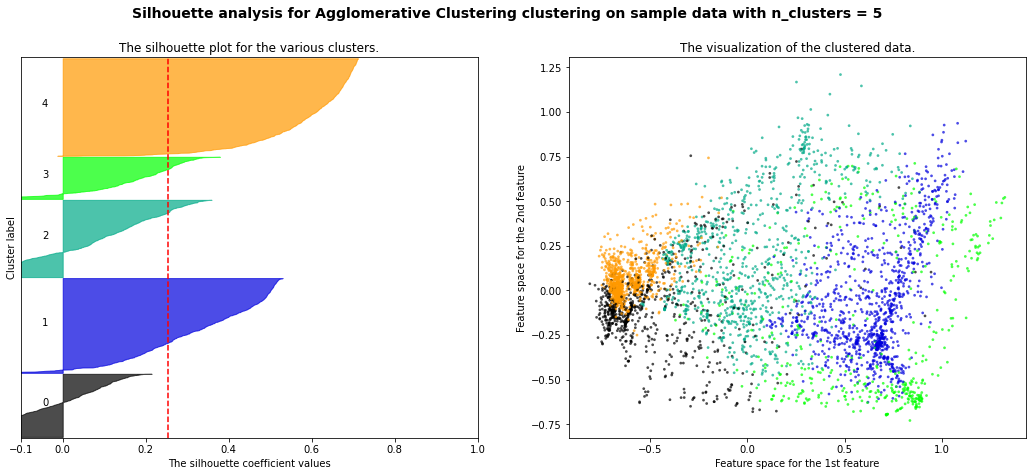

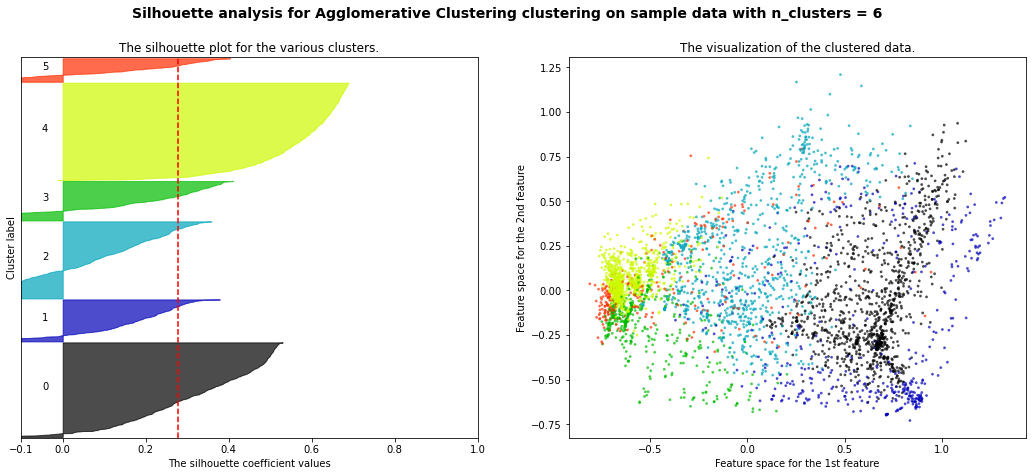

In [691]:
plot_silhouette(AgglomerativeClustering, K, df_pca, 'Agglomerative Clustering')

> 5 dimensions PCA Agglomerative

For n_clusters = 2 The average silhouette_score is : 0.3772957183248108
For n_clusters = 3 The average silhouette_score is : 0.34961039840053354
For n_clusters = 4 The average silhouette_score is : 0.36331271826016753
For n_clusters = 5 The average silhouette_score is : 0.3563688651174481
For n_clusters = 6 The average silhouette_score is : 0.308711833497983


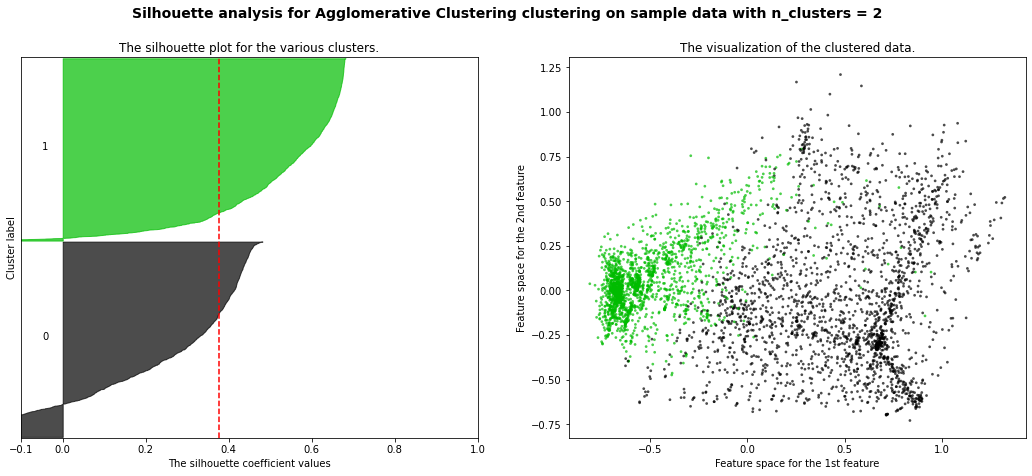

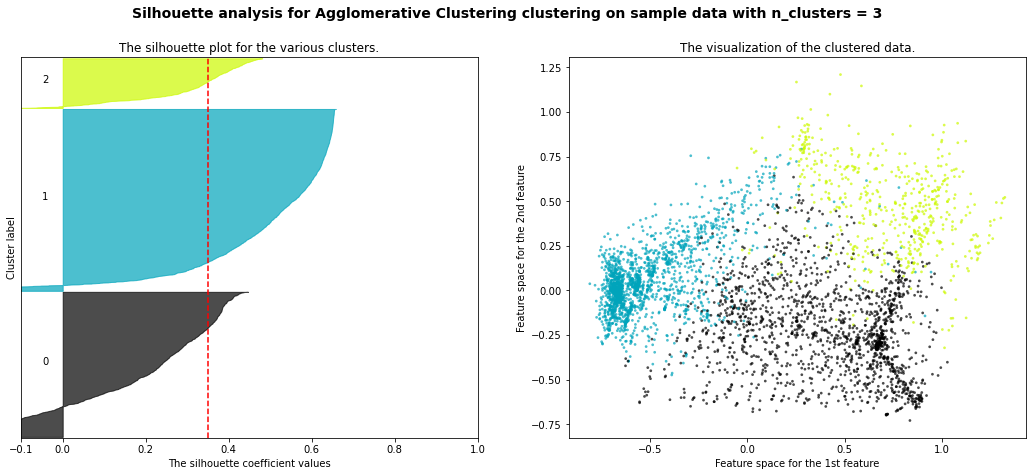

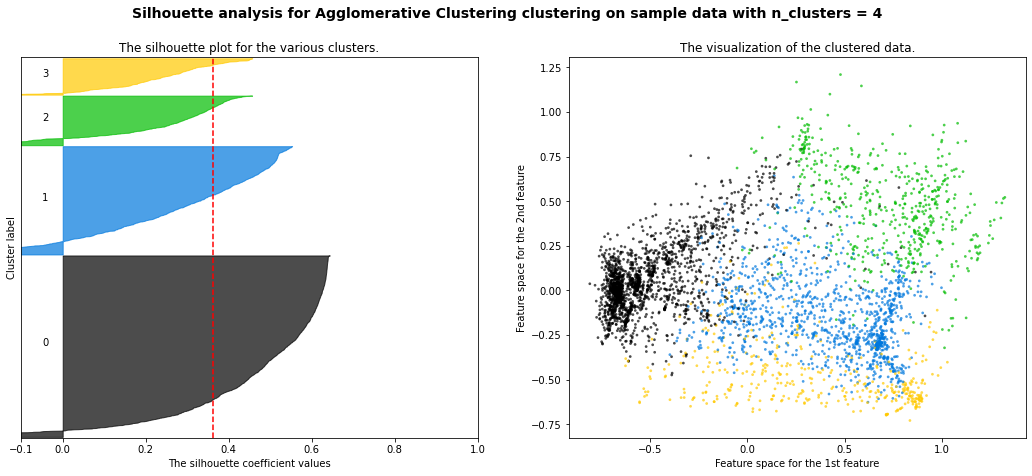

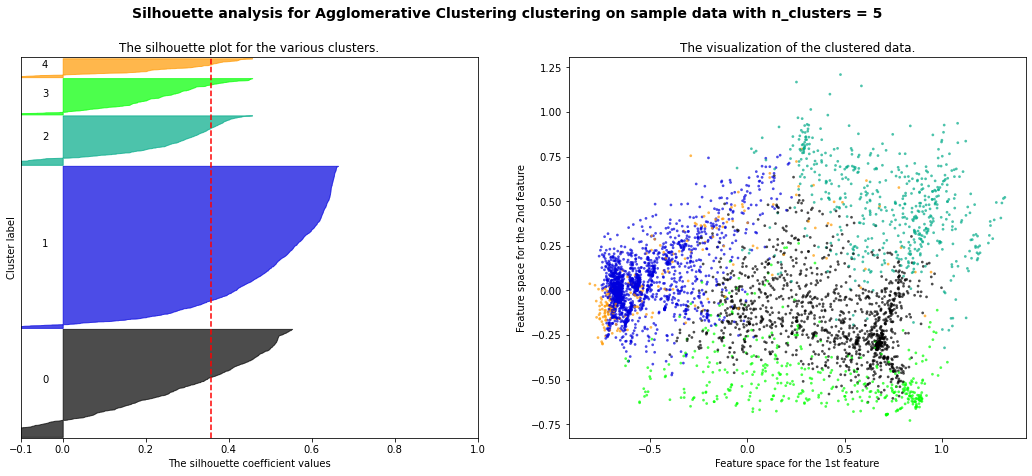

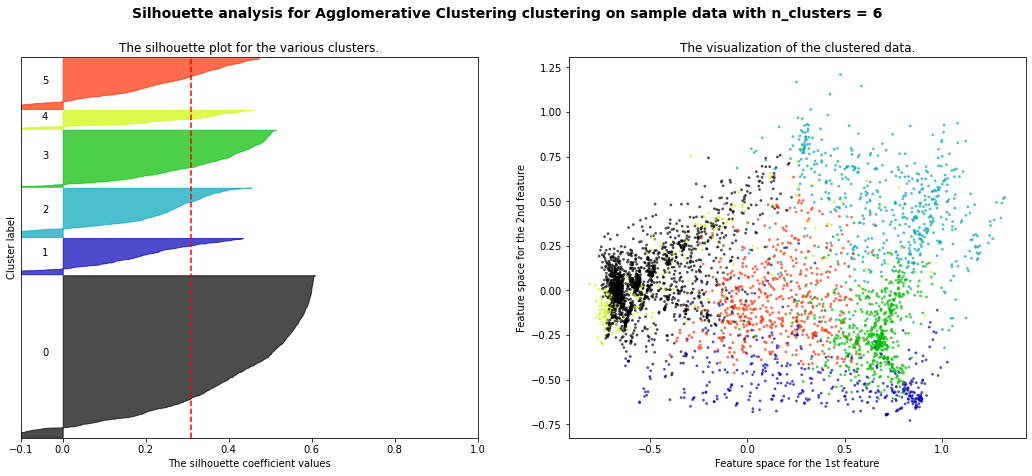

In [692]:
plot_silhouette(AgglomerativeClustering, K, df_pca2, 'Agglomerative Clustering')

> From Agglomerative's silhouette score, the best score is generated by the PCA'd data with the 5 dimensions, which is the ncluster = 2. Proceeding with said model.

In [693]:
agg = AgglomerativeClustering(n_clusters=2)
df_comp['agglo'] = agg.fit_predict(df_pca2)
df_comp

balance  balance_frequency  purchases  oneoff_purchases  \
1      943.584041           0.875000     103.00            103.00   
3      461.455720           1.000000     585.00            585.00   
4     1053.594730           1.000000    1450.00           1450.00   
5     2237.238086           1.000000     120.00            120.00   
7      424.994385           0.375000    1200.00           1200.00   
...           ...                ...        ...               ...   
4470  1079.008102           1.000000       0.00              0.00   
4471   809.582978           0.909091       0.00              0.00   
4472  3386.490883           1.000000     560.98            427.22   
4473  4840.545574           1.000000    1595.93           1595.93   
4474  1977.007090           1.000000    1032.04            226.90   

      installments_purchases  cash_advance  purchases_frequency  \
1                       0.00      0.000000             0.125000   
3                       0.00      0.000000             0.125000   
4                       0.00      0.000000             0.125000   
5                       0.00      0.000000             0.125000   
7                       0.00      0.000000             0.125000   
...                      ...           ...                  ...   
4470                    0.00   1259.571764             0.000000   
4471                    0.00   3819.672466             0.000000   
4472                  133.76   2008.153534             1.000000   
4473                    0.00   4359.325750             0.454545   
4474                  805.14   4335.919227             0.909091   

      oneoff_purchases_frequency  purchases_installments_frequency  \
1                       0.125000                          0.000000   
3                       0.125000                          0.000000   
4                       0.125000                          0.000000   
5                       0.125000                          0.000000   
7                       0.125000                          0.000000   
...                          ...                               ...   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.727273                          0.363636   
4473                    0.454545                          0.000000   
4474                    0.090909                          0.818182   

      cash_advance_frequency  ...  purchases_trx  credit_limit     payments  \
1                   0.000000  ...              1        1000.0   215.325023   
3                   0.000000  ...              1        1000.0   258.032630   
4                   0.000000  ...              1        1500.0   397.090516   
5                   0.000000  ...              1        2500.0   343.102984   
7                   0.000000  ...              1        1200.0    57.266292   
...                      ...  ...            ...           ...          ...   
4470                0.545455  ...              0        1200.0  1379.635287   
4471                0.545455  ...              0        4150.0  4372.148648   
4472                0.545455  ...             20       10100.0  1039.000037   
4473                0.545455  ...             25        6000.0   905.844846   
4474                0.545455  ...             17        4000.0  3056.424974   

      minimum_payments  prc_full_payment  tenure  k-means_auto  k-means_elkan  \
1           410.484825          0.000000       8             1              0   
3           151.696433          0.000000       8             1              0   
4           227.143184          0.000000       8             1              0   
5           712.986387          0.000000       8             1              0   
7            56.720210          0.000000       8             1              0   
...                ...               ...     ...           ...            ...   
4470        271.364

> Now that all the model is implemented, let's conduct an EDA to investigate the generated cluster.

# **8. Cluster Exploratory Analysis**

> First, let's see the correlation score

## **8. 1. Correlation**

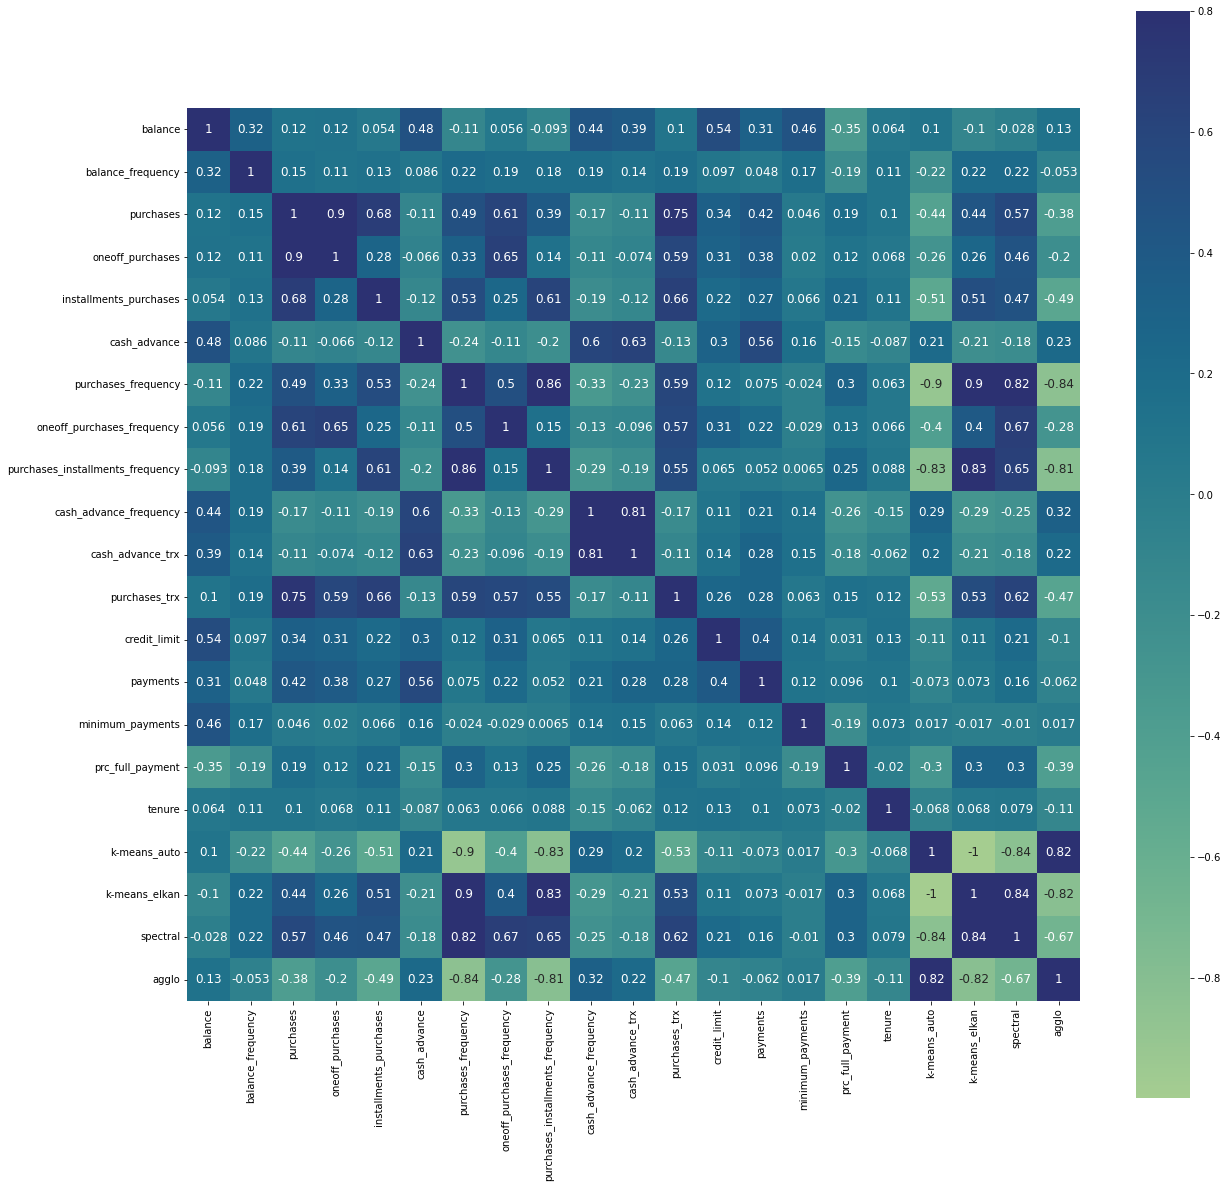

<Figure size 1440x1080 with 0 Axes>

In [694]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df_comp.corr(method='pearson'), vmax=.8, square=True, annot=True, cmap='crest', annot_kws={"fontsize":12});

plt.figure(figsize=(20,15))
plt.show()

> Insight from correlation matrix
- K-Means Auto
    - Positive correlation (thresh: 0.4):
        - None
    - Negative correlation (thresh: 0.4):
        - `purchases_frequency` = -0.9
        - `purchases_installments_frequency` = -0.83
        - `purchases_trx` = -53
        - `installments_purchases` = -0.51
        - `purchases` = -0.44
    - Insight:
        - With the treshold 0.4, K-Means Auto seems to focus on negative correlation on its labeling.
        - Which means, label 0 is for the high purchases_frequency and 1 for low purchases_frquency. So does with other columns.
        - We will focus on these column more on Cluster Analysis. 
<br><br>
- K-Means Elkan:
    - Positive correlation (thresh: 0.4):
        - None
    - Negative correlation (thresh 0.4):
        - `purchases_frequency` = -0.9
        - `purchases_installments_frequency` = -0.83
        - `purchases_trx` = -53
        - `installments_purchases` = -0.51
        - `purchases` = -0.44
    - Insight:
        - Elkan and Auto has the same number which means it doesn't have any difference between these two algorithm technique.
<br><br>     
- Spectral Clustering
    - Positive correlation (thresh: 0.4):
        - `installments_purchases` = 0.46
        - `purchases_frequency` = 0.82
        - `purchases_installments_frequency` = 0.85
        - `purchases_trx` = 0.39 (close to assigned thresh)
    - Negative correlation (thresh: 0.4):
        - None
    - Insight:
        - With the treshold 0.4, Spectral seems to focus on positive correlation.
        - Which mean, label 0 is for lower purchases_frequency (and so on), and label 1 is for high purchases_frequency.
        - The number of feature considered is less than K-Means.
        - We will focus on these columns more on Cluster Analysis.
<br><br>
- Agglomerative Clustering
    - Postive correlation (thresh: 0.4)
        - None
    - Negative correlation (thresh: 0.4)
        - `purchases` = -0.42
        - `installment_purchases` = -0.51
        - `purchases_frequency` = -0.81
        - `purchases_installments_frequency` = -0.78
        - `purchases_trx` = -0.52
    - Insight:
        - Just like k-means, Agglomerative model seems to focus on negative correlations.
        - We will focus on columns above more on Cluster Analysis.

## **8. 2. Label Distribution**

Text(0.5, 1.0, 'K-Means Auto')

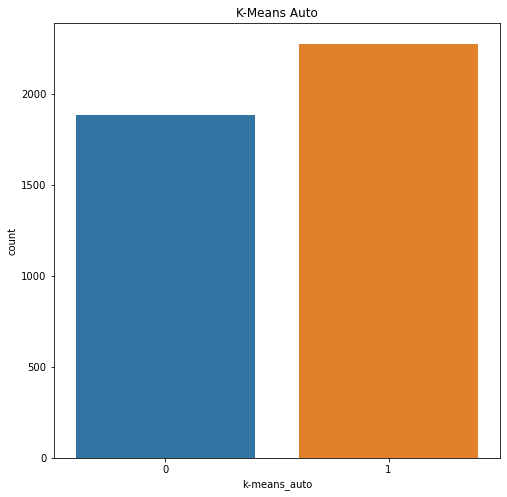

In [695]:
sns.countplot(data=df_comp, x='k-means_auto')
plt.title('K-Means Auto')

In [696]:
df_comp['k-means_auto'].value_counts()

1    2275
0    1882
Name: k-means_auto, dtype: int64

Text(0.5, 1.0, 'K-Means Elkan')

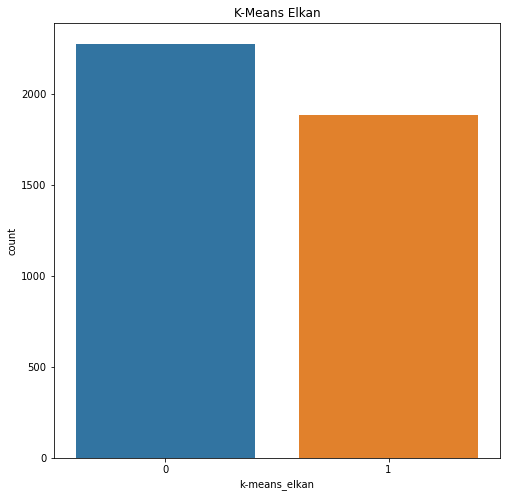

In [697]:
sns.countplot(data=df_comp, x='k-means_elkan')
plt.title('K-Means Elkan')

In [698]:
df_comp['k-means_elkan'].value_counts()

0    2274
1    1883
Name: k-means_elkan, dtype: int64

Text(0.5, 1.0, 'Spectral Clustering')

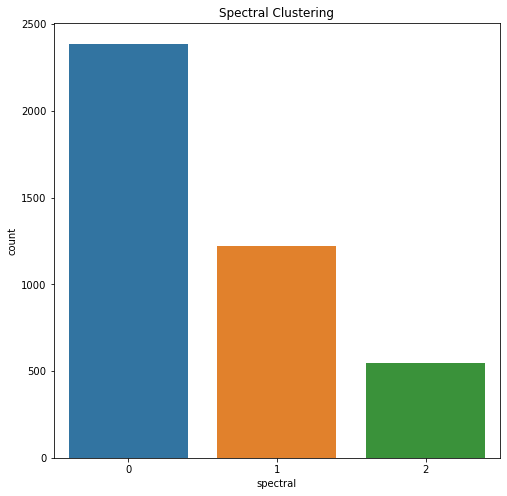

In [699]:
sns.countplot(data=df_comp, x='spectral')
plt.title('Spectral Clustering')

In [700]:
df_comp['spectral'].value_counts()

0    2388
1    1221
2     548
Name: spectral, dtype: int64

Text(0.5, 1.0, 'Agglomerative Clustering')

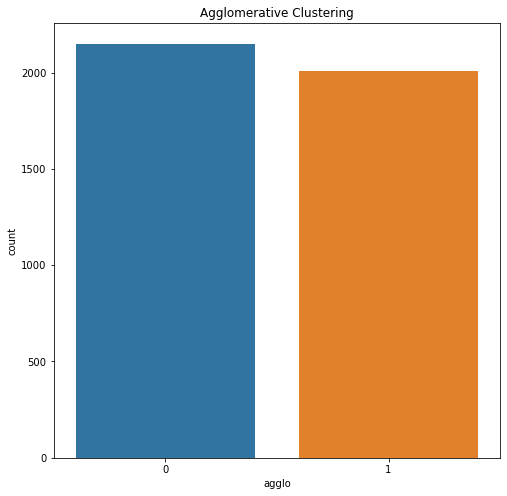

In [701]:
sns.countplot(data=df_comp, x='agglo')
plt.title('Agglomerative Clustering')

In [702]:
df_comp['agglo'].value_counts()

0    2150
1    2007
Name: agglo, dtype: int64

> Insight from label distribution:
1. K-Means
    - Whether it is with 'auto' or 'elkan', label 1 is more than label 0, however, it's pretty close to balance compared to other model.
    - Strangely enough, 'auto' and 'elkan' have exactly same label distribution.
2. Spectral Clustering
    - label 0 is the most out of other labels (1 and 2).
    - the distribution is not very balanced.
    - Assumption: If we compare spectral's label distribution with k-means' label distribution, spectral's label 1 is the sub-cluster (or derivation) from label 2. Which means, label 1 is taken from label 2.
3. Agglomerative Clustering
    - label 1 is more than label 0.
    - compared to k-means, the distribution between label is far from balanced.

## **8. 3. Distribution**

In [703]:
df_comp.columns

Index(['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment',
       'tenure', 'k-means_auto', 'k-means_elkan', 'spectral', 'agglo'],
      dtype='object')

K-Means Auto Label Distribution


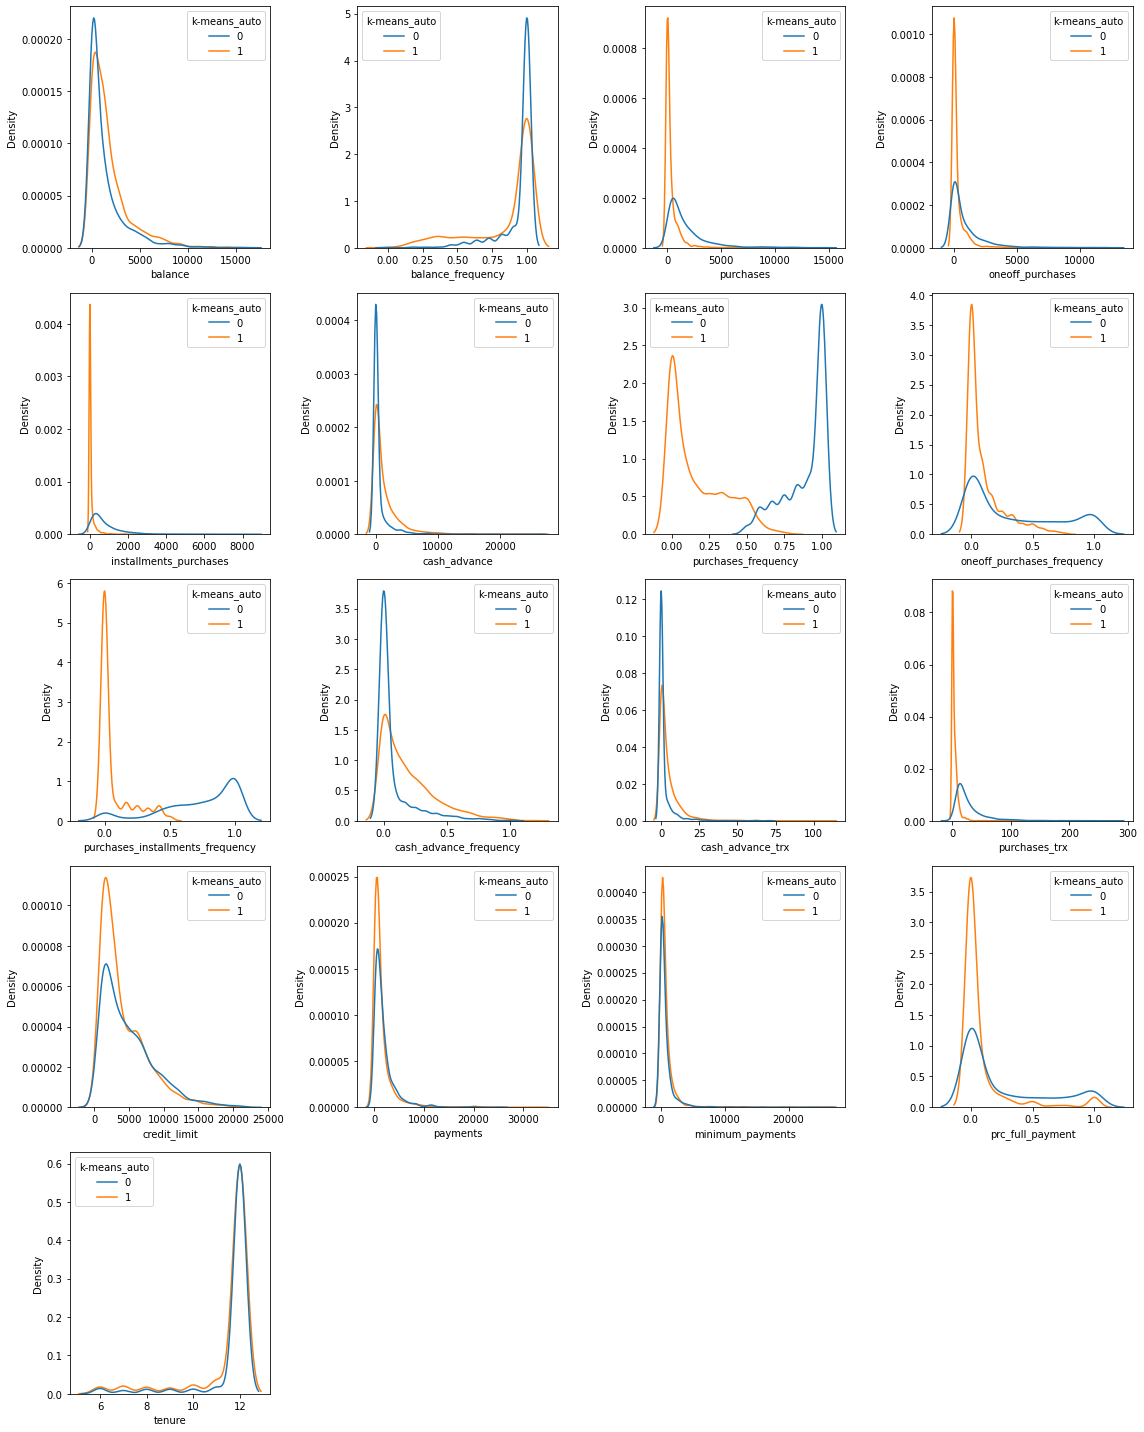

In [704]:
cols = 4
rows = 5
num_cols = df_comp[['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment',
       'tenure',]].columns
fig = plt.figure( figsize=(cols*4, rows*4))
print('K-Means Auto Label Distribution')

for i, col in enumerate(num_cols):
    ax=fig.add_subplot(rows,cols,i+1)
    sns.kdeplot(x = df[col], hue=df_comp['k-means_auto'], ax = ax)
    
fig.tight_layout()  
plt.show()

> Insight for K-Means (Auto) label distribution:
- From `purchases_frequency` we can see that the label is divided from 'the low' and 'the high' section of `purchases_frequency`.
- Label 1 = low `purchases_frequency`, while label 0 = high `purchases_frequency`. This can be interpreted that customer who use their credit card frequently is categorized as 0
- Same as `purchaes_frequency`, `purchases_installments_frequency` is also divided from 'low' and 'high' section.
- 1 = low, while 0 = high. Which means that customer who frequenty purchase equipment or facilities is categorized as '0'.
- `purchases_trx` and `installments_purchases` are also applied with the same manner. The lower part is categorized as '1', and the higher section is categorized as '0'.
- for `purchases` it applies the same as well. The lower section is categorized as '1' and vice versa.

Conclusion:<br>
> For K-Means:
- '1' is for the lower customer card usage frequency
- '0' is for higher customer card usage frequency

> We can interpret this as:
- customer loyalty (high = 0, low = 1)
- customer dependability to credit card (high = 0, low = 1)

> Note: Since K-Means (Auto) and K-Means (Elkan) has the same value, the insight is applied to both model.

> Proceeding to Spectral Clustering...

Spectral Label Distribution


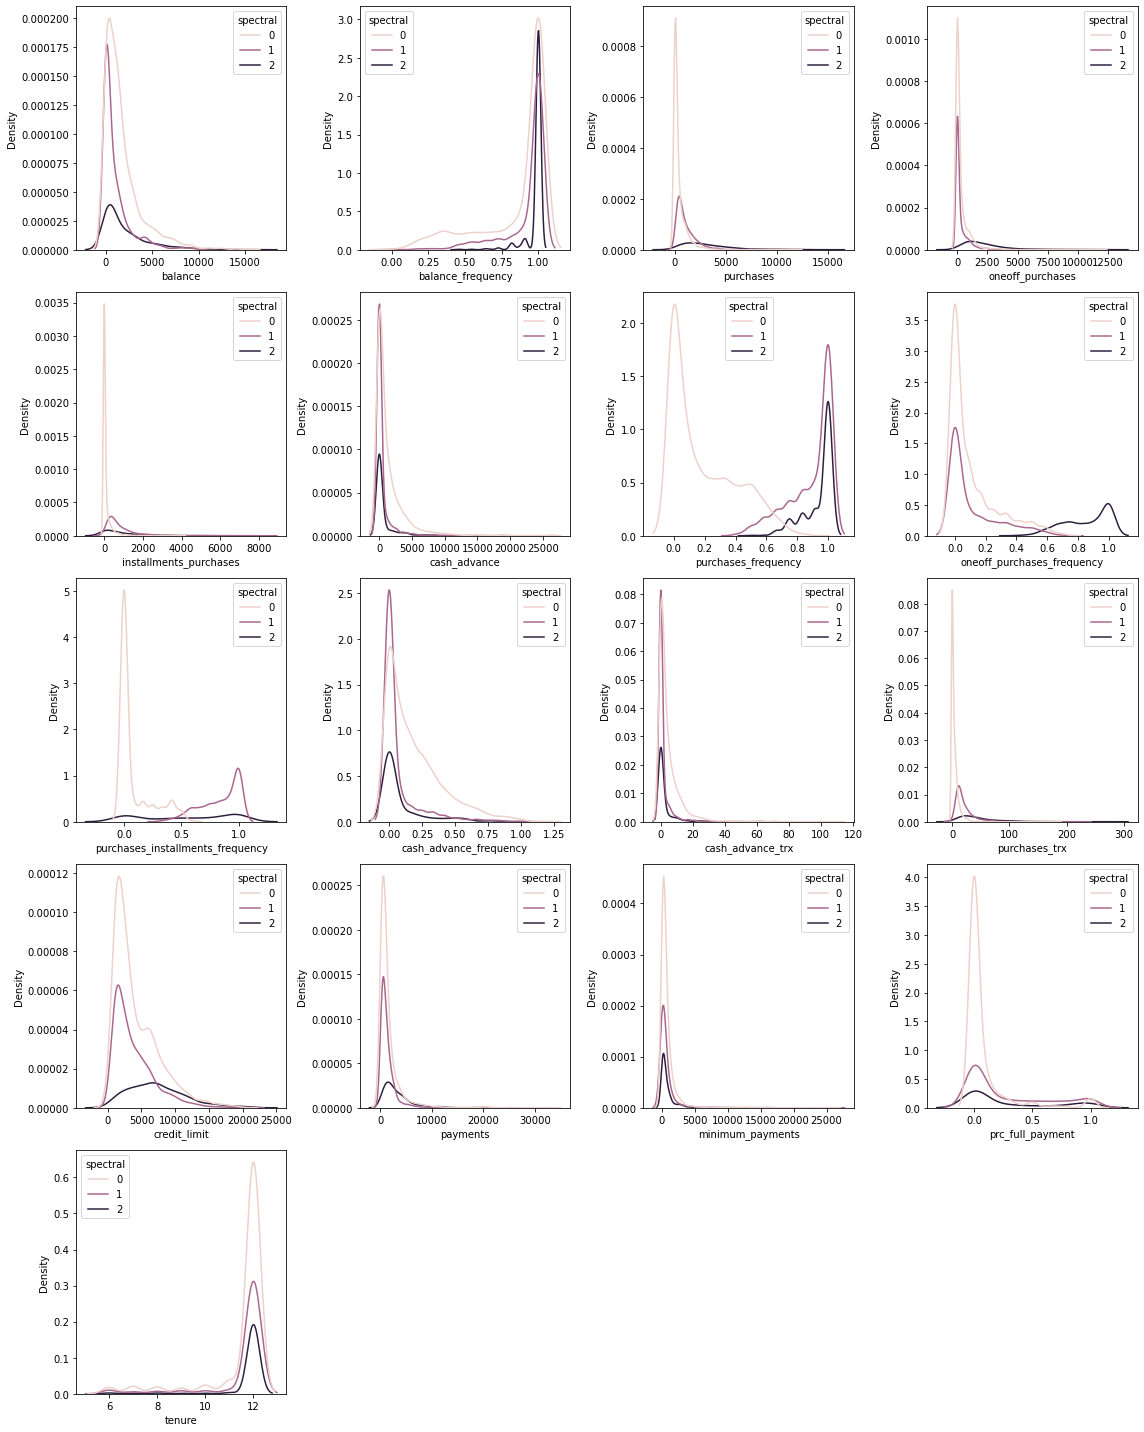

In [705]:
cols = 4
rows = 5
num_cols = df_comp[['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment',
       'tenure',]].columns
fig = plt.figure( figsize=(cols*4, rows*4))
print('Spectral Label Distribution')

for i, col in enumerate(num_cols):
    ax=fig.add_subplot(rows,cols,i+1)
    sns.kdeplot(x = df[col], hue=df_comp['spectral'], ax = ax)
    
fig.tight_layout()  
plt.show()

> Definition:<br>
> - oneoff : purchase in one payment (ind: tidak menunggak)

> Insight for Spectral Clustering label distribution:
- From `purchases_frequency` 0 is for the lower section, 1 and 2 is for the higher section.
- There's rlatively unclear definition between '1' and '2' since almost in all column, this 2 labels are mostly overlapped. However, from `purchases_installments_frequency`, there's a certain range that is filled with label 1, when it comes to the treshold crosses 1.x. 
- For most cases, 1 and 2 are in the same range, but 1 has lower density.
- There's one exception where 1 is defined well which is in the column `oneoff_purchases_frequency`, where '1' has high distribution above the threshold of 0.6 frequency.
- There's also one column, `oneoff_purchases` where above 2500 that 1 is defined clearly
- 1 is also has higher credit limit compared to 2. This proves previous insight. When a customer able to pay on one go, bank trusted them with high credit limit.

Conclusion:<br>
- '0' is for the lower customer card usage frequency
- '2' is for higher customer card usage frequency
- '1' is the higher customer card usage who has high oneoff purchases.

> We can interpret this that spectral clustering divide the customer as:
- customer type of card usage frequency = (low = 0, high = 2, high but low debt = 1)

Agglomerative Clustering Label Distribution


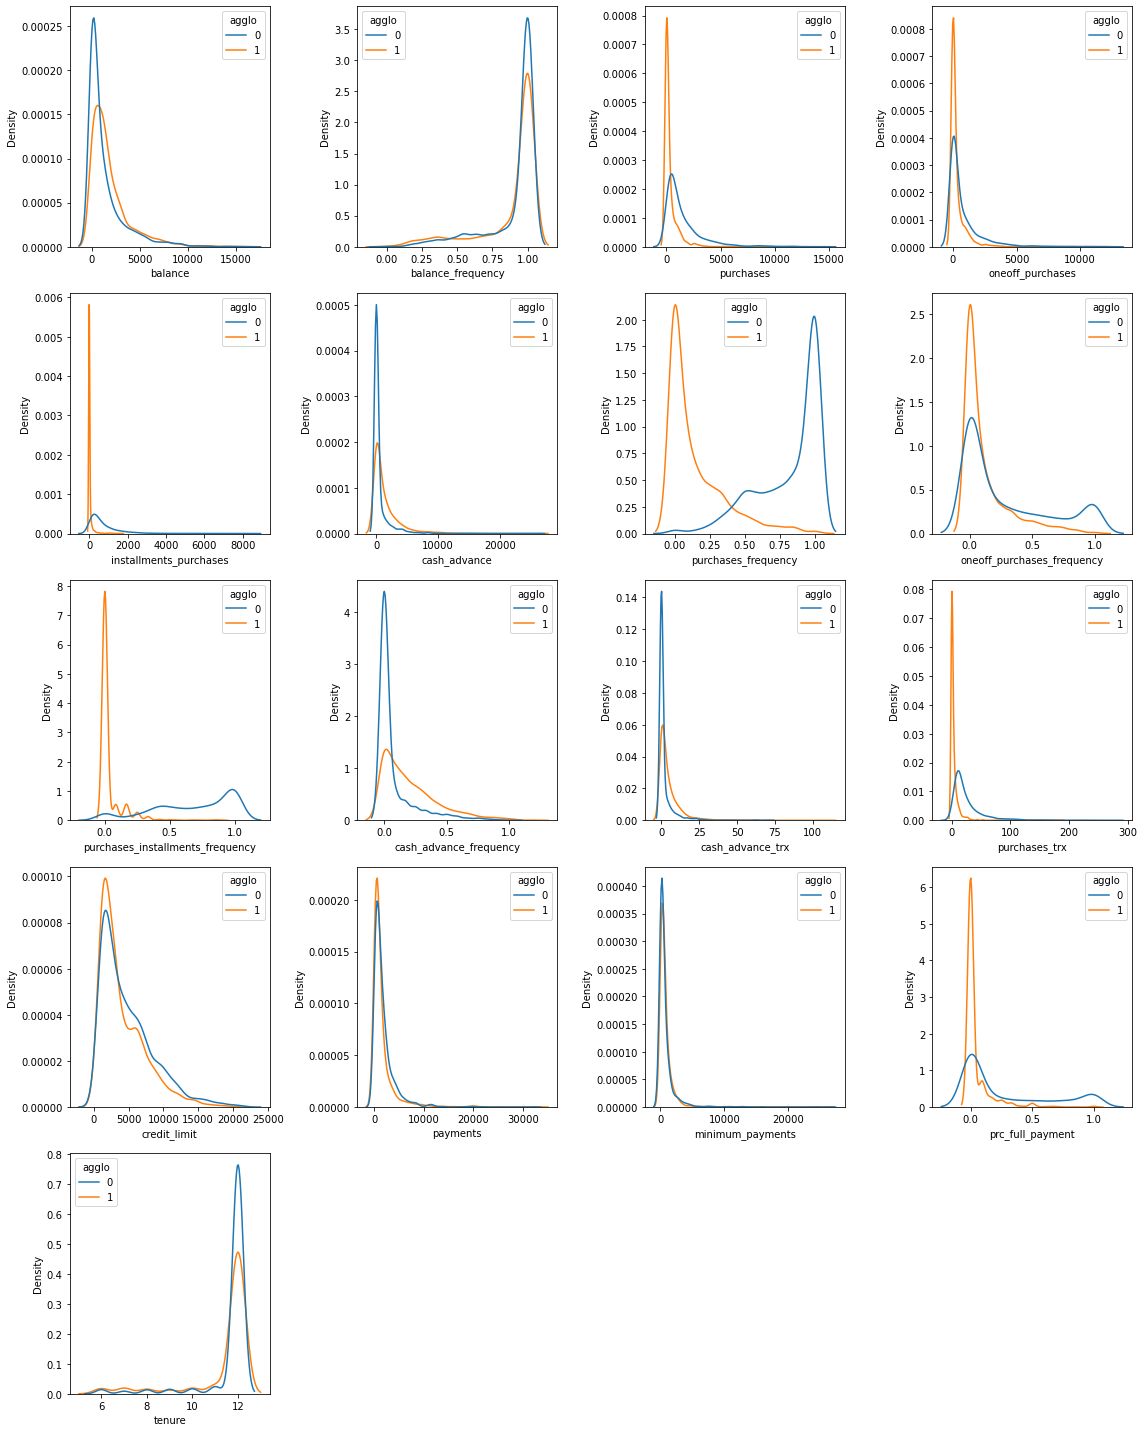

In [706]:
cols = 4
rows = 5
num_cols = df_comp[['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment',
       'tenure',]].columns
fig = plt.figure( figsize=(cols*4, rows*4))
print('Agglomerative Clustering Label Distribution')

for i, col in enumerate(num_cols):
    ax=fig.add_subplot(rows,cols,i+1)
    sns.kdeplot(x = df[col], hue=df_comp['agglo'], ax = ax)
    
fig.tight_layout()  
plt.show()

> Insight for Agglomerative Clustering label distribution:
- The cluster is not as defined as k-means.
- In the column `purchases_frequency` where 1 and 0 is clearly defined. However there's a certain range, 1.x, which is in the higher section. This part of distribution makes the categorization is a little bit unclear.
- from `purchases_installment_frequency` as well, the 1 and 0 seems overlapped but different in density. 1 is for low `purchases_installment_frequency` where 0 is for the higher.
- from `purchaes_frequency` aswell, 1 is for the lower section, where 0 is for the higher section. But we still can't put aside that there's still high number of overlap distributions.
- from `purchases_trx`, 1 is also for the lower section, and 0 for the higher.

> Conclusion:
- Agglomerative model seems to mainly clustering based on purchases columns. The lower section of the purchases' amount and frequency will be labeled as 1 and 0 will be labeled otherwise.

> Now that we defined the cluster, let's evaluate the model

# **9. Model Evaluation**

In [707]:
modellist = kmn, kmn2, agg, spectral
score_calinski_harabasz = []
score_shillouette = []
model = []
for x in modellist:
  labels = x.labels_
  y = metrics.calinski_harabasz_score(df_scaled, labels)
  s = metrics.silhouette_score(df_scaled, labels)
  score_calinski_harabasz.append(y)
  score_shillouette.append(s)
  model.append(str(x))

result = pd.DataFrame(data=zip(score_calinski_harabasz,score_shillouette, model), columns=['score_calinski_harabasz','score_shillouette','model'])
result

score_calinski_harabasz  score_shillouette  \
0              2595.750451           0.364296   
1              2595.805132           0.364279   
2              2193.284332           0.329009   
3              1846.106499           0.352813   

                                     model  
0                     KMeans(n_clusters=2)  
1  KMeans(algorithm='elkan', n_clusters=2)  
2                AgglomerativeClustering()  
3         SpectralClustering(n_clusters=3)

> Insight:
- Based on calinski harabasz' score, K-means is the best model since it has the highest score.
- The worst model is Spectral Clustering, but has higher silhouette score compared to Agglomerative.

> Now that we defined the best model, let's implement the inferencing to the best model (K-Means)

# **10. Inferencing**

In [708]:
df_inf.drop(columns='cust_id', inplace=True)
df_inf.head()

balance  balance_frequency  purchases  oneoff_purchases  \
2785  4785.789559           1.000000       0.00              0.00   
4299   951.309137           1.000000     137.03            137.03   
1911    99.256215           0.636364    1554.39           1174.39   
3439  2640.820976           0.900000    1167.86              0.00   
3636  3146.619037           1.000000     161.44            161.44   

      installments_purchases  cash_advance  purchases_frequency  \
2785                    0.00   8422.554694             0.000000   
4299                    0.00   1171.933912             0.111111   
1911                  380.00      0.000000             0.636364   
3439                 1167.86   3463.175221             0.800000   
3636                    0.00   1293.405174             0.166667   

      oneoff_purchases_frequency  purchases_installments_frequency  \
2785                    0.000000                          0.000000   
4299                    0.111111                          0.000000   
1911                    0.454545                          0.181818   
3439                    0.000000                          0.700000   
3636                    0.166667                          0.000000   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
2785                0.875000                25              0        9500.0   
4299                0.111111                 2              3        1200.0   
1911                0.000000                 0              9        6000.0   
3439                0.600000                15             13        8000.0   
3636                0.333333                 5              3        4000.0   

         payments  minimum_payments  prc_full_payment  tenure  
2785   687.474829       1010.781349               0.0       8  
4299   312.729653        269.716306               0.0       9  
1911  1006.702329        139.902685               0.5      11  
3439   538.132963        641.479689               0.0      10  
3636   888.223787        746.243829               0.0      12

> Scaling

In [709]:
df_inf_scaled = scaler.transform(df_inf)

> Applying PCA

In [710]:
df_inf_pca = PCA(n_components=5).fit_transform(df_inf_scaled)
print('Dimension: ', len(pd.DataFrame(df_inf_pca).columns))

Dimension:  5


> Clustering with selected K-means model

In [711]:
df_inf['credit_card_usage'] = kmn2.predict(df_inf_pca)
df_inf

balance  balance_frequency  purchases  oneoff_purchases  \
2785  4785.789559           1.000000       0.00              0.00   
4299   951.309137           1.000000     137.03            137.03   
1911    99.256215           0.636364    1554.39           1174.39   
3439  2640.820976           0.900000    1167.86              0.00   
3636  3146.619037           1.000000     161.44            161.44   
3988  1608.163254           1.000000    1130.60           1130.60   
1705   242.530010           1.000000    3520.00              0.00   
1167  3441.516174           1.000000     358.68              0.00   
4453  4899.638221           1.000000       0.00              0.00   
1435   130.890211           0.363636     131.26              0.00   
1936  1832.940008           1.000000    1839.69            914.19   
4167  6046.821082           1.000000     502.48            502.48   
2606  1615.967240           1.000000     102.00            102.00   
1126    20.996733           0.909091     295.92              0.00   
3857  1794.531623           1.000000       0.00              0.00   
1244    35.460649           0.909091     378.58            378.58   
2235   890.633006           0.909091     756.73            756.73   
2349  1597.911395           1.000000       0.00              0.00   
4078  4117.751094           1.000000     159.07            159.07   
3668  7021.942957           1.000000       0.00              0.00   
4376  4393.939007           1.000000     417.08            417.08   
2804  2579.635387           0.545455       0.00              0.00   
4000   708.509086           1.000000    2109.61           1734.61   
4422   778.475416           1.000000     353.52            158.00   
87     768.881695           0.727273     408.59            408.59   
962    408.656365           1.000000     941.64              0.00   
2516  1283.337407           1.000000    1022.41            171.60   
531   3817.693096           1.000000    4974.27           3825.87   
861   1544.621765           1.000000    1534.12             26.50   
2202  1112.070216           1.000000     179.24             59.00   

      installments_purchases  cash_advance  purchases_frequency  \
2785                    0.00   8422.554694             0.000000   
4299                    0.00   1171.933912             0.111111   
1911                  380.00      0.000000             0.636364   
3439                 1167.86   3463.175221             0.800000   
3636                    0.00   1293.405174             0.166667   
3988                    0.00    682.525873             1.000000   
1705                 3520.00      0.000000             0.916667   
1167                  358.68      0.000000             1.000000   
4453                    0.00    424.449434             0.000000   
1435                  131.26      0.000000             0.333333   
1936                  925.50      0.000000             0.583333   
4167                    0.00   3143.218022             0.200000   
2606                    0.00    244.840485             0.166667   
1126                  295.92      0.000000             1.000000   
3857                    0.00   1050.199464             0.000000   
1244                    0.00      0.000000             0.083333   
2235                    0.00      0.000000             0.416667   
2349                    0.00    162.919727             0.000000   
4078                    0.00   2940.082863             0.166667   
3668                    0.00   3217.327939             0.000000   
4376                    0.00   2126.961648             0.250000   
2804                    0.00   6466.733810             0.000000   
4000                  375.00    366.008558             1.000000   
4422                  195.52   1183.478018             0.666667   
87                      0.00      0.000000             0.250000   
962                   941.64      0.000000             1.000000   
2516                  850.81   1158.035224             0.8750

> Defining the label with `high` and `low`

In [714]:
df_inf['credit_card_usage'] = df_inf['credit_card_usage'].apply(str)
df_inf["credit_card_usage"] = df_inf['credit_card_usage'].str.replace('1', 'low')
df_inf['credit_card_usage'] = df_inf['credit_card_usage'].str.replace('0', 'high')
df_inf.head(10)    

balance  balance_frequency  purchases  oneoff_purchases  \
2785  4785.789559           1.000000       0.00              0.00   
4299   951.309137           1.000000     137.03            137.03   
1911    99.256215           0.636364    1554.39           1174.39   
3439  2640.820976           0.900000    1167.86              0.00   
3636  3146.619037           1.000000     161.44            161.44   
3988  1608.163254           1.000000    1130.60           1130.60   
1705   242.530010           1.000000    3520.00              0.00   
1167  3441.516174           1.000000     358.68              0.00   
4453  4899.638221           1.000000       0.00              0.00   
1435   130.890211           0.363636     131.26              0.00   

      installments_purchases  cash_advance  purchases_frequency  \
2785                    0.00   8422.554694             0.000000   
4299                    0.00   1171.933912             0.111111   
1911                  380.00      0.000000             0.636364   
3439                 1167.86   3463.175221             0.800000   
3636                    0.00   1293.405174             0.166667   
3988                    0.00    682.525873             1.000000   
1705                 3520.00      0.000000             0.916667   
1167                  358.68      0.000000             1.000000   
4453                    0.00    424.449434             0.000000   
1435                  131.26      0.000000             0.333333   

      oneoff_purchases_frequency  purchases_installments_frequency  \
2785                    0.000000                          0.000000   
4299                    0.111111                          0.000000   
1911                    0.454545                          0.181818   
3439                    0.000000                          0.700000   
3636                    0.166667                          0.000000   
3988                    1.000000                          0.000000   
1705                    0.000000                          0.916667   
1167                    0.000000                          0.916667   
4453                    0.000000                          0.000000   
1435                    0.000000                          0.333333   

      cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
2785                0.875000                25              0        9500.0   
4299                0.111111                 2              3        1200.0   
1911                0.000000                 0              9        6000.0   
3439                0.600000                15             13        8000.0   
3636                0.333333                 5              3        4000.0   
3988                0.166667                 4             19        2500.0   
1705                0.000000                 0             11         650.0   
1167                0.000000                 0             12        7500.0   
4453                0.272727                 5              0        5000.0   
1435                0.000000                 0              4        3000.0   

         payments  minimum_payments  prc_full_payment  tenure  \
2785   687.474829       1010.781349          0.000000       8   
4299   312.729653        269.716306          0.000000       9   
1911  1006.702329        139.902685          0.500000      11   
3439   538.132963        641.479689          0.000000      10   
3636   888.223787        746.243829          0.000000      12   
3988  1152.859524        996.573517          0.000000      12   
1705  3814.912997       3236.664860          0.333333      12   
1167  1376.000823        751.654272          0.000000      12   
4453   880.262447       1651.415614          0.000000      11   
1435   763.568532         67.294065          0.090909      12   

     credit_card_usage  
2785              high  
4299              high  
1911               low  
3439               low  
3636              high  
3988 

# **11. Conclusion**

For this assignment, the conclusion for the clustering are:
- The best model is K-means with 2 clusters.
- The model segmented the cluster with low and high credit card usage.
- Can also be interpreted as high and low credit card dependability.
- This model can be used to cluster customer's credit card activity if we want to increase customer's card activity from low to high by target marketing.
- This model can also be used to gather information what our market looks like. We can expand our target market with similar characteristics.
- This clustering can also be used to further analysis to customer's churn rate by investigate the `low` customer further.
- The model can also be improved since the silhouette score is still low. However, with k-means, the cluster seems to be defined well.

# **12. Conceptual Question**

> Apakah yang dimaksud dengan inertia pada algoritma K-Means ?

- Inersia mengukur seberapa baik kumpulan data dikelompokkan oleh K-Means. Untuk pengelompokan yang lebih baik, nilai inersia harus minimum. Sebaliknya, jika nilai inersianya tinggi, berarti titik-titik data dalam cluster tersebut tidak mirip satu sama lain.

> Jelaskan yang dimaksud dengan Elbow Method (alasan penggunaan, cara penggunaan, kelemahan/kelebihan, dll) !

- metode yang digunakan untuk menentukan nilai optimal k untuk melakukan clustering. Ide dasar di balik metode ini adalah memplot berbagai nilai perubahan k. Titik di mana distorsi ini paling menurun adalah titik siku, yang berfungsi sebagai nilai k yang optimal.

> Jelaskan perbedaan masing-masing algoritma clustering yang anda gunakan dalam kasus ini !

- K-Means

Algoritma pengelompokan K-means menghitung centroid dan iterasi sampai kita menemukan centroid yang optimal. Diasumsikan bahwa jumlah cluster sudah diketahui. Ini juga disebut algoritma pengelompokan datar. Jumlah cluster yang diidentifikasi dari data oleh algoritma diwakili oleh 'K' dalam K-means. Kelemahan K-means adalah terlalu bergantung dengan titik centroid sehingga tidak pernah tahu cluster yang sebenarnya. Dengan menggunakan data yang sama, jika diinput dengan urutan yang berbeda bisa menghasilkan cluster yang berbeda juga.

- Spectral Clustering

Spectral clustering bekerja dengan cara mengubah data dari ruang Cartesian dan diproyeksikan ke space baru dan kemudian mengelompokkannya dalam space tersebut. Data asli diproyeksikan ke ruang koordinat baru yang menyandikan informasi tentang seberapa dekat titik antar data. Karena proses proyeksi tadi, spectral secara tidak langsung mengurangi dimensi data. Spectral juga tidak memerlukan centroid sehingga memiliki hasil yang lebih stabil. Kelemahan Spectral Clustering yaitu diproses sangat lama.

- Agglomerative Clustering

Agglomerative (agg) adalah cara clustering dengan cara hierarki. Agg membagi populasi menjadi beberapa cluster sedemikian rupa sehingga titik data dalam cluster yang sama lebih mirip dan titik data dalam cluster berbeda berbeda. Kekurangan agglomerative adalah jarang memberikan cluster yang baik dan terlalu banyak melibatkankeputusan yang acak.


